In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

plt.rcParams["font.family"] = "sans-serif"
#plt.rcParams["font.serif"] = ["Times New Roman"]
plt.rcParams['svg.fonttype'] = 'none'
dpi=400
TIME_FOR_BOUND=10
ALLOW_SKIP_FOR_BOUND=1
h2o_color = '#df0303'
h2o_light_color = '#f29a9a'
# checked water by binding site type seperated by agreement to cryoem - no interesting patterns
# checked water+mg by binding site type seperated by force field - no interesting patterns
# checked max time - no intresting patterns
# tried violinplots - obscurs interesting patterns

In [7]:
# occupancy bind?
mg_in = f"Mg_vals_bind_dist2.2_time10_skip1_rmsdcut3.4.csv"
na_in = f"Na_vals_bind_dist2.5_time10_skip1_rmsdcut3.4.csv"
wat_in = f"wat_vals_bind_dist3.2_time10_skip1_rmsdcut3.4.csv"
mgin = pd.read_csv(mg_in)
nain = pd.read_csv(na_in)
watin = pd.read_csv(wat_in)

def correct_for_time_limit_allow_skip(dists,time_lim,skip,ret_list=[],curr_list=[],curr_length=0,curr_skip=0):
    if dists==[]:
        if curr_length>=time_lim:
            return ret_list+curr_list
        else:
            return ret_list+([np.nan]*len(curr_list))
    else:
        if curr_list == []:
            if np.isnan(dists[0]):
                return correct_for_time_limit_allow_skip(dists[1:],time_lim,skip,
                                                         ret_list=ret_list+[np.nan],
                                                         curr_list=[],curr_length=0,curr_skip=0)
            else:
                return correct_for_time_limit_allow_skip(dists[1:],time_lim,skip,
                                                         ret_list=ret_list,
                                                         curr_list=[dists[0]],curr_length=1,curr_skip=0)
        else:
            if curr_skip>=skip and np.isnan(dists[0]):
                if curr_length>=time_lim:
                    return correct_for_time_limit_allow_skip(dists[1:],time_lim,skip,
                                                             ret_list=ret_list+curr_list+[np.nan],
                                                             curr_list=[],curr_length=0,curr_skip=0)
                else:
                    return correct_for_time_limit_allow_skip(dists[1:],time_lim,skip,
                                                             ret_list=ret_list+([np.nan]*(len(curr_list)+1)),
                                                             curr_list=[],curr_length=0,curr_skip=0)
            elif np.isnan(dists[0]):
                return correct_for_time_limit_allow_skip(dists[1:],time_lim,skip,
                                                         ret_list=ret_list,
                                                         curr_list=curr_list+[np.nan],curr_length=curr_length,curr_skip=curr_skip+1)
            else:
                return correct_for_time_limit_allow_skip(dists[1:],time_lim,skip,
                                                         ret_list=ret_list,
                                                         curr_list=curr_list+[dists[0]],curr_length=curr_length+1,curr_skip=0)

In [8]:
cols = watin.drop(columns=['simulation', 'other_atom', 'bind_site', 'atom_types', 'bind_name']).columns
watin = watin[watin.isnull().sum(axis=1) <= len(cols)-TIME_FOR_BOUND]
watin[cols] = watin[cols].apply(lambda row: pd.Series(correct_for_time_limit_allow_skip(row.to_list(),TIME_FOR_BOUND,ALLOW_SKIP_FOR_BOUND)),axis=1)
watin = watin[watin.isnull().sum(axis=1) <= len(cols)-TIME_FOR_BOUND]

In [9]:
occupancy_wat = watin.drop(columns=["other_atom","bind_site","atom_types"]).groupby(['simulation','bind_name']).count()
occupancy = occupancy_wat.replace(0, np.NaN).mean(axis=1).reset_index().groupby(['simulation','bind_name']).mean()[0].to_dict()
occupancy = {''.join(x):y for x,y in occupancy.items()}

In [13]:
# get binding site data
mg_out = f"Mg_restimes_bind_dist2.2_time10_skip1_rmsdcut3.4.csv"
na_out = f"Na_restimes_bind_dist2.5_time10_skip1_rmsdcut3.4.csv"
wat_out = f"wat_restimes_bind_dist3.2_time10_skip1_rmsdcut3.4.csv"
mg = pd.read_csv(mg_out)
na = pd.read_csv(na_out)
wat = pd.read_csv(wat_out)
mg['sum_res_time'] = mg.groupby(['bind_site','simulation','atom_types'])['res_time'].transform('sum')
na['sum_res_time'] = na.groupby(['bind_site','simulation','atom_types'])['res_time'].transform('sum')
wat['sum_res_time'] = wat.groupby(['bind_site','bind_name','simulation','atom_types'])['res_time'].transform('sum')
df22_water_mdsim = pd.read_csv(f"../water_consensus/wat_md_dist3.2_time10_skip1_rmsdcut3.4.csv")
em_state = dict(zip(df22_water_mdsim['RNA_atoms'],df22_water_mdsim['2A category']))
wat['em_state'] = wat.bind_name.map(em_state)
wat['occupancy'] = (wat.simulation+wat.bind_name).map(occupancy)


def simplify_water(atoms):
    bind_type = ''
    if 'OP' in atoms:
        bind_type += "OP"
    if "O2'" in atoms or "ribose" in atoms:
        bind_type += "Or"
    if "carbonyl" in atoms:
        bind_type+="Ob"
    if 'ketimine' in atoms or 'amine' in atoms:
        bind_type += 'Nb'
    return bind_type
wat['atoms'] = wat.atom_types.apply(lambda x: simplify_water(x))
wat_sum = wat.groupby(['bind_name','em_state','occupancy','simulation']).res_time.agg(['mean','sum']).reset_index()

wat_plot = wat.groupby(['bind_name','em_state','occupancy','simulation']).res_time.agg(['mean','sum','max']).reset_index().copy()
wat_plot['sum/occ'] = wat_plot['sum']/wat_plot.occupancy
wat_plot['mean/sum'] = wat_plot.occupancy*wat_plot['mean']/wat_plot['sum']
wat_plot['max/sum'] = wat_plot.occupancy*wat_plot['max']/wat_plot['sum']

In [14]:
from scipy import stats
def Kruskal_and_mannwhitney(g1,g2,g3):
    s_overall,p_overall = stats.kruskal(g1,g2,g3, nan_policy='omit')
    print(f"Kruskal: {s_overall}, p={p_overall}")
    print(len(g1),len(g2),len(g3))
    g1 = g1[~np.isnan(g1)]
    g2 = g2[~np.isnan(g2)]
    g3 = g3[~np.isnan(g3)]
    print('mean',g1.mean(),g2.mean(),g3.mean())
    print('median',np.median(g1),np.median(g2),np.median(g3))
    print('Q3',np.percentile(g1,75),np.percentile(g2,75),np.percentile(g3,75))
    t_none_all, p_none_all = stats.mannwhitneyu(g3, g1)
    print(f"mannwhitneyu non-all: {t_none_all}, p={p_none_all}")
    t_none_some, p_none_some = stats.mannwhitneyu(g3, g2)
    print(f"mannwhitneyu non-some: {t_none_some}, p={p_none_some}")
    t_some_all, p_some_all = stats.mannwhitneyu(g2, g1)
    print(f"mannwhitneyu some-all: {t_some_all}, p={p_some_all}")
    t_X, p_X = stats.mannwhitneyu(np.append(g1,g2),g3)
    print(f"mannwhitneyu em-none: {t_X}, p={p_X}")
    return p_overall,p_none_all,p_none_some,p_some_all,g3.mean(),g2.mean(),g1.mean()#np.percentile(g3,75),np.percentile(g2,75),np.percentile(g1,75)#

def get_sig(p):
    if p>0.05: sig="n.s."
    elif p>0.0001:  sig="*"
    elif p>0.000001: sig="**"
    elif p>0.00000001: sig="***"
    else: sig="****"
    return sig


Kruskal: 38.45418233319183, p=4.464577881093094e-09
299 468 2183
mean 97.01550816623006 69.03775317515723 68.10613620884126
median 53.285714285714285 37.568322981366464 38.375
Q3 122.5625 68.51602564102564 65.8
mannwhitneyu non-all: 255207.5, p=4.6102278013997814e-10
mannwhitneyu non-some: 505440.0, p=0.36011774796170315
mannwhitneyu some-all: 54658.0, p=1.5676634386047154e-07
mannwhitneyu em-none: 771411.5, p=0.000595232523130458
Kruskal: 170.68947009860028, p=8.614944989038935e-38
1130 2209 17438
mean 38.22844861329085 27.11497941149247 22.135610760808476
median 15.69047619047619 14.5 13.666666666666666
Q3 29.0 22.0 19.0
mannwhitneyu non-all: 7878316.0, p=4.6282012687110484e-30
mannwhitneyu non-some: 17406142.0, p=6.868137184345215e-14
mannwhitneyu some-all: 1112851.5, p=1.4127507374476023e-07
mannwhitneyu em-none: 25284458.0, p=6.610339519218315e-34


/tmp/ipykernel_158418/818884357.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.violinplot(data=wat_sum_200only, y='mean', x='em_state',
/tmp/ipykernel_158418/818884357.py:13: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  g = sns.violinplot(data=wat_sum_200only, y='mean', x='em_state',
/tmp/ipykernel_158418/818884357.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  x=g.set_xticklabels( ('Both','One','None'),
/tmp/ipykernel_158418/818884357.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.violinplot(data=wat_plot, y='mean', x='em_state',ax = axes[0],
/tmp/ipykerne

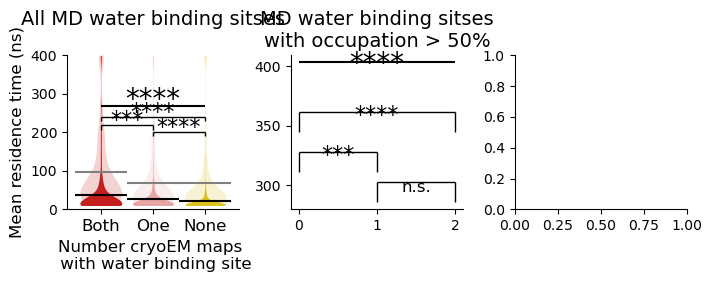

In [16]:
fig,axes = plt.subplots(1,3,figsize=(8,2),sharex=False,sharey=False)
plt.subplots_adjust(hspace=0.1,wspace=0.3)



wat_sum_200only = wat_plot[wat_plot['sum/occ']>160]

g1 = wat_sum_200only[wat_sum_200only.em_state=="Water binding site found in both cryoEM maps."]['mean'].values
g2 = wat_sum_200only[wat_sum_200only.em_state=="Water binding site found in only one cryoEM maps."]['mean'].values
g3 = wat_sum_200only[wat_sum_200only.em_state=="Water binding site not found in any cryoEM maps."]['mean'].values
p_overall,p_none_all,p_none_some,p_some_all,mean_2,mean_1,mean_0 = Kruskal_and_mannwhitney(g1,g2,g3)
    
g = sns.violinplot(data=wat_sum_200only, y='mean', x='em_state',
                 palette={"Water binding site found in both cryoEM maps.":h2o_color,
                      "Water binding site found in only one cryoEM maps.":h2o_light_color,
                     "Water binding site not found in any cryoEM maps.":"gold"},
                order = ["Water binding site found in both cryoEM maps.",
                      "Water binding site found in only one cryoEM maps.",
                     "Water binding site not found in any cryoEM maps."],
                       cut=0,scale="width",inner=None,linewidth=0,ax=axes[0])#,ax=ax,orient=orient)
x=g.set_xticklabels( ('Both','One','None'),
                           fontsize=12,rotation=0)

x=g.set_xlabel("Number cryoEM maps \n with water binding site",size=12)
x=g.set_ylabel("",size=12)

for violin in g.collections[::]:
    violin.set_alpha(0.2)
g.hlines(mean_0,-0.5,0.5,"grey")
g.hlines(mean_1,0.5,1.5,"grey")
g.hlines(mean_2,1.5,2.5,"grey")

ax = axes[1]
maxtime=1.4*300
text_to_add = [get_sig(p) for p in [p_overall,p_none_all,p_none_some,p_some_all]]
sizes = [16 if x!="n.s." else 12 for x in text_to_add]
sizes[0] += 4
x_adjust = [-0.02 if x!="n.s." else 0.02 for x in text_to_add]
ax.text(1,maxtime*(0.96+x_adjust[0]),text_to_add[0],rotation=0,size=sizes[0],ha="center")
ax.hlines(maxtime*0.96,0,2,"black")
ax.text(1,maxtime*(0.86+x_adjust[1]),text_to_add[1],rotation=0,size=sizes[1],ha="center")
ax.hlines(maxtime*0.86,0,2,"black",linewidth=1)
ax.vlines(0,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.vlines(2,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.text(0.5,maxtime*(0.78+x_adjust[3]),text_to_add[3],rotation=0,size=sizes[3],ha="center")
ax.hlines(maxtime*0.78,0,1,"black",linewidth=1)
ax.vlines(0,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.vlines(1,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.text(1.5,maxtime*(0.72+x_adjust[3]),text_to_add[2],rotation=0,size=sizes[2],ha="center")
ax.hlines(maxtime*0.72,1,2,"black",linewidth=1)
ax.vlines(1,maxtime*0.72,maxtime*0.68,"black",linewidth=1)
ax.vlines(2,maxtime*0.72,maxtime*0.68,"black",linewidth=1)
sns.despine()

g1 = wat_plot[wat_plot.em_state=="Water binding site found in both cryoEM maps."]['mean'].values
g2 = wat_plot[wat_plot.em_state=="Water binding site found in only one cryoEM maps."]['mean'].values
g3 = wat_plot[wat_plot.em_state=="Water binding site not found in any cryoEM maps."]['mean'].values
p_overall,p_none_all,p_none_some,p_some_all,mean_2,mean_1,mean_0 = Kruskal_and_mannwhitney(g1,g2,g3)
    
g = sns.violinplot(data=wat_plot, y='mean', x='em_state',ax = axes[0],
                 palette={"Water binding site found in both cryoEM maps.":h2o_color,
                      "Water binding site found in only one cryoEM maps.":h2o_light_color,
                     "Water binding site not found in any cryoEM maps.":"gold"},
                order = ["Water binding site found in both cryoEM maps.",
                      "Water binding site found in only one cryoEM maps.",
                     "Water binding site not found in any cryoEM maps."],
                       cut=0,scale="width",inner=None,linewidth=0)#,ax=ax,orient=orient)
x=g.set_xticklabels( ('Both','One','None'),
                           fontsize=12,rotation=0)
g.hlines(mean_0,-0.5,0.5,"black")
g.hlines(mean_1,0.5,1.5,"black")
g.hlines(mean_2,1.5,2.5,"black")

axes[0].set_title("All MD water binding sitses\n ",size=14)
x=g.set_xlabel("Number cryoEM maps \n with water binding site",size=12)
#x=g.set_ylabel("Single water binding event\naverage fraction of total\nwater occupancy for that binding site",size=12)
x=g.set_ylabel("Mean residence time (ns)",size=12)

#"Average site occupancy (# waters) \nx Average site residence time (ns) \n/ Sum site residence times (ns)",size=12)
axes[1].set_title("MD water binding sitses\nwith occupation > 50%",size=14)
ax = axes[0]
maxtime=1.4*200
text_to_add = [get_sig(p) for p in [p_overall,p_none_all,p_none_some,p_some_all]]
sizes = [16 if x!="n.s." else 12 for x in text_to_add]
sizes[0] += 4
x_adjust = [-0.02 if x!="n.s." else 0.02 for x in text_to_add]
ax.text(1,maxtime*(0.96+x_adjust[0]),text_to_add[0],rotation=0,size=sizes[0],ha="center")
ax.hlines(maxtime*0.96,0,2,"black")
ax.text(1,maxtime*(0.86+x_adjust[1]),text_to_add[1],rotation=0,size=sizes[1],ha="center")
ax.hlines(maxtime*0.86,0,2,"black",linewidth=1)
ax.vlines(0,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.vlines(2,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.text(0.5,maxtime*(0.78+x_adjust[3]),text_to_add[3],rotation=0,size=sizes[3],ha="center")
ax.hlines(maxtime*0.78,0,1,"black",linewidth=1)
ax.vlines(0,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.vlines(1,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.text(1.5,maxtime*(0.72+x_adjust[3]),text_to_add[2],rotation=0,size=sizes[2],ha="center")
ax.hlines(maxtime*0.72,1,2,"black",linewidth=1)
ax.vlines(1,maxtime*0.72,maxtime*0.68,"black",linewidth=1)
ax.vlines(2,maxtime*0.72,maxtime*0.68,"black",linewidth=1)

ax.set_ylim(0,400)

plt.savefig(f"residence_time_fractional_binding_sites_mean_time.svg",bbox_inches="tight",transparent=True)
plt.savefig(f"residence_time_fractional_binding_sites_mean_time.png", dpi=dpi,bbox_inches="tight",transparent=True)

In [2]:
import pandas as pd
# import utils
import sys, os
parent_dir = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), ''))
sys.path.insert(0,parent_dir)
from utils import *
import MDAnalysis
from MDAnalysis.analysis import align
from sys import argv
import os 

dfcon = pd.read_csv('../water_consensus/all_solvent_consensus_status_withconsensus.csv')
df22wat = dfcon[(dfcon.model=='2.2Å') & (dfcon.solvent=="HOH")].copy()
df23wat = dfcon[(dfcon.model=='2.3Å') & (dfcon.solvent=="HOH")].copy()

df22wat['Consensus'] = df22wat['consensus of wat in 2.3Å']#((df22wat['within 1A of wat in 2.3Å']>0) & (df22wat['exact binding spot of wat in 2.3Å']>0))
df23wat['Consensus'] = df23wat['consensus of wat in 2.2Å']#((df23wat['within 1A of wat in 2.2Å']>0) & (df23wat['exact binding spot of wat in 2.2Å']>0))

con22 = df22wat[df22wat.Consensus].residue_number.to_list()
con23 = df23wat[df23wat.Consensus].residue_number.to_list()

sim_frames = pd.melt(pd.read_csv('../water_consensus/wat_reports_bind_dist3.2_time10_skip1_rmsdcut3.4.csv'),id_vars=['simulation','other_atom']).rename(columns={'value':'bind','variable':'frame'})
model = PDB22_F #PDB23_F
u22 = MDAnalysis.Universe(model)
# and 2.2A!/2,3
# get all waters and their binding sites
waters = u22.select_atoms(WAT_SELECTION)
print(len(waters))
conrmsf,nconrmsf=[],[]
conrmsf_group,nconrmsf_group=[],[]
for i,atom in tqdm(enumerate(waters)):
    rmsfs = []
    binding_site = u22.select_atoms(f"({RNA_SELECTION}) and around {WAT_MAX_DIST} (resname {atom.resname} and resnum {atom.resnum} and name {atom.name})")
    bind = [str(atom.resnum-21)+"_"+atom.resname+"_"+atom.name if atom.name not in ["OP1","OP2"] else str(atom.resnum-21)+"_"+atom.resname+"_"+"OP" for atom in binding_site]
    bind = [x for x in sorted(bind,key=lambda pair: (int(pair.split('_')[0]),pair.split('_')[2]))]
    bind = ' '.join(bind)
    
    binding_site = u22.select_atoms(f"({RNA_SELECTION}) and around {WAT_MED_DIST} (resname {atom.resname} and resnum {atom.resnum} and name {atom.name})")
    close = [str(atom.resnum-21)+"_"+atom.resname+"_"+atom.name if atom.name not in ["OP1","OP2"] else str(atom.resnum-21)+"_"+atom.resname+"_"+"OP" for atom in binding_site]
    close = [x for x in sorted(close,key=lambda pair: (int(pair.split('_')[0]),pair.split('_')[2]))]
    close = ' '.join(close)

    overlap = sim_frames.bind.apply(lambda x: get_number_exact_overlap2([x],close,bind))>0
        #[bind],x)>0)
    frame_to_align = sim_frames[overlap].groupby(['simulation','other_atom']).frame.apply(list).reset_index()
    #print(frame_to_align)
    length_events = frame_to_align.frame.apply(len)
    start_i = 0 
    if os.path.isfile(f'sim_coords/22_{i}.csv'):
        df = pd.read_csv(f'sim_coords/22_{i}.csv')
        for length in length_events:
            if length>10:
                dft = df.iloc[start_i:start_i+length].copy()
                avg = dft.mean()
                rmsf = np.sqrt(((dft-avg)**2).sum(axis=1)[2:-2].sum()/(len(dft)-4))
                rmsfs.append(rmsf)
                if atom.resnum in con22:
                    conrmsf.append(rmsf)
                else:
                    nconrmsf.append(rmsf)
            
            start_i += length
    if atom.resnum in con22:
        if len(rmsfs) == 0:
            print("NO EM",bind)
        else:
            conrmsf_group.append(sum(rmsfs)/len(rmsfs))
    else:
        if len(rmsfs) == 0:
            print("NO EM",bind)
        else:
            nconrmsf_group.append(sum(rmsfs)/len(rmsfs))
            
model = PDB23_F #PDB23_F
u22 = MDAnalysis.Universe(model)
waters = u22.select_atoms(WAT_SELECTION)
print(len(waters))
for i,atom in tqdm(enumerate(waters)):
    rmsfs = []
    binding_site = u22.select_atoms(f"({RNA_SELECTION}) and around {WAT_MAX_DIST} (resname {atom.resname} and resnum {atom.resnum} and name {atom.name})")
    bind = [str(atom.resnum-21)+"_"+atom.resname+"_"+atom.name if atom.name not in ["OP1","OP2"] else str(atom.resnum-21)+"_"+atom.resname+"_"+"OP" for atom in binding_site]
    bind = [x for x in sorted(bind,key=lambda pair: (int(pair.split('_')[0]),pair.split('_')[2]))]

    bind = ' '.join(bind)
    binding_site = u22.select_atoms(f"({RNA_SELECTION}) and around {WAT_MED_DIST} (resname {atom.resname} and resnum {atom.resnum} and name {atom.name})")
    close = [str(atom.resnum-21)+"_"+atom.resname+"_"+atom.name if atom.name not in ["OP1","OP2"] else str(atom.resnum-21)+"_"+atom.resname+"_"+"OP" for atom in binding_site]
    close = [x for x in sorted(close,key=lambda pair: (int(pair.split('_')[0]),pair.split('_')[2]))]
    close = ' '.join(close)

    overlap = sim_frames.bind.apply(lambda x: get_number_exact_overlap2([x],close,bind))>0
        #[bind],x)>0)
    frame_to_align = sim_frames[overlap].groupby(['simulation','other_atom']).frame.apply(list).reset_index()
    #print(frame_to_align)
    length_events = frame_to_align.frame.apply(len)
    start_i = 0 
    if os.path.isfile(f'sim_coords/23_{i}.csv'):
        df = pd.read_csv(f'sim_coords/23_{i}.csv')
        for length in length_events:
            if length>10:
                dft = df.iloc[start_i:start_i+length].copy()
                avg = dft.mean()
                rmsf = np.sqrt(((dft-avg)**2).sum(axis=1)[2:-2].sum()/(len(dft)-4))
                rmsfs.append(rmsf)
                if atom.resnum in con23:
                    conrmsf.append(rmsf)
                else:
                    nconrmsf.append(rmsf)
            
            start_i += length
    if atom.resnum in con23:
        if len(rmsfs) == 0:
            print("NO EM",bind)
        else:
            conrmsf_group.append(sum(rmsfs)/len(rmsfs))
    else:
        if len(rmsfs) == 0:
            print("NO EM",bind)
        else:
            nconrmsf_group.append(sum(rmsfs)/len(rmsfs))
# rmsf errorrs???
#print(conrmsf)
#print(nconrmsf)
with open('conrmsf.txt', 'w+') as f:
    for r in conrmsf:
        f.write(f'{r}\n')
with open('nconrmsf.txt', 'w+') as f:
    for r in nconrmsf:
        f.write(f'{r}\n')
with open('conrmsf_grouped.txt', 'w+') as f:
    for r in conrmsf_group:
        f.write(f'{r}\n')
with open('nconrmsf_grouped.txt', 'w+') as f:
    for r in nconrmsf_group:
        f.write(f'{r}\n')

RDKit WARNING: [11:29:37] Enabling RDKit 2019.09.3 jupyter extensions
[11:29:37] Enabling RDKit 2019.09.3 jupyter extensions
/tmp/ipykernel_3157/816619692.py:22: DtypeWarning: Columns (78,86,103,105,109,110,120,122,123,127,128,129,130,131,134,136,137,139,152,163,183,188,190,192,193,194,196,198,199,200,201,202,203,205,206,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,260,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,3

263


1it [00:11, 11.46s/it]

NO EM 76_A_C8 76_A_O5' 76_A_OP 77_C_C5 77_C_OP 279_U_O2


2it [00:22, 11.45s/it]

NO EM 237_U_OP 239_C_C2' 239_C_O2 239_C_O2' 239_C_O3' 284_U_O5'


3it [00:36, 12.20s/it]

NO EM 248_A_C1' 248_A_N3 249_A_C8 249_A_O4' 283_A_N6


4it [00:49, 12.91s/it]

NO EM 197_A_N6 233_G_O2' 234_C_N1 234_C_O4' 252_U_O2' 252_U_O3'


5it [01:02, 12.85s/it]

NO EM 258_G_O6 259_G_N7 259_G_O6


6it [01:14, 12.62s/it]

NO EM 84_A_O2' 85_U_C4' 85_U_O4' 194_G_N2 195_C_O2 237_U_O2 237_U_O2'


7it [01:30, 13.55s/it]

NO EM 83_A_N1 197_A_N1 234_C_N3 234_C_O2 251_G_N2


8it [01:43, 13.41s/it]

NO EM 87_G_N7 238_U_C3' 238_U_C4' 238_U_O2' 238_U_O3'


9it [01:55, 12.83s/it]

NO EM 81_C_C5 82_A_C8 82_A_N7 248_A_C2' 248_A_C8 248_A_OP


10it [02:06, 12.45s/it]

NO EM 285_A_C2 285_A_C4 285_A_N3 286_U_C4 286_U_O4


11it [02:17, 11.83s/it]

NO EM 77_C_N4 279_U_C2 279_U_N3


12it [02:28, 11.73s/it]

NO EM 285_A_N3 287_A_N6 287_A_N7


13it [02:40, 11.69s/it]

NO EM 196_C_N4 234_C_OP 236_G_C6 236_G_O6


14it [02:51, 11.58s/it]

NO EM 257_C_C5 258_G_N7


15it [03:04, 12.16s/it]

NO EM 236_G_O3' 236_G_OP 237_U_OP 283_A_O2' 283_A_O3' 284_U_OP


16it [03:17, 12.30s/it]

NO EM 235_A_C2 235_A_N1 281_A_OP 282_G_OP


17it [03:29, 12.25s/it]

NO EM 83_A_N6 236_G_C4' 236_G_O2' 249_A_N6


18it [03:41, 12.22s/it]

NO EM 164_U_C4' 165_A_C5' 165_A_OP


19it [03:54, 12.34s/it]

NO EM 145_C_OP 147_U_OP 167_G_O6


20it [04:06, 12.25s/it]

NO EM 192_C_C5 192_C_N4 193_A_N6 193_A_N7


21it [04:18, 12.12s/it]

NO EM 78_C_C5 78_C_N4


22it [04:30, 12.04s/it]

NO EM 78_C_N4 79_G_N7


23it [04:43, 12.54s/it]

NO EM 250_U_O2 282_G_C2' 282_G_N3 282_G_O5' 282_G_OP


24it [04:57, 12.82s/it]

NO EM 82_A_N3 83_A_N7 84_A_N6 248_A_N6


25it [05:09, 12.62s/it]

NO EM 246_U_O4 285_A_C2 285_A_N1


26it [05:21, 12.44s/it]

NO EM 288_G_N2 321_A_C2' 321_A_N3 321_A_O2'


27it [05:33, 12.20s/it]

NO EM 238_U_C2 238_U_N3 238_U_O2


28it [05:45, 12.11s/it]

NO EM 37_G_C2 37_G_N2 37_G_N3 37_G_O2' 38_U_O4' 74_A_C2 75_G_N2 75_G_N3 75_G_O2' 76_A_O4'


29it [05:56, 11.95s/it]

NO EM 194_G_O6 195_C_N4


30it [06:08, 12.00s/it]

NO EM 85_U_O2


31it [06:20, 11.99s/it]

NO EM 198_A_N3 252_U_O2


32it [06:32, 11.83s/it]

NO EM 234_C_O2' 235_A_C5' 236_G_OP


33it [06:43, 11.74s/it]

NO EM 247_A_N6 247_A_N7 248_A_N6


34it [06:55, 11.77s/it]

NO EM 147_U_C5' 147_U_OP 149_C_OP 150_A_C8 150_A_N7


35it [07:07, 11.89s/it]

NO EM 147_U_OP 162_A_N6


35it [07:11, 12.33s/it]


KeyboardInterrupt: 

In [25]:
import os
simno = pd.read_csv('../water_consensus/wat_reports_bind_dist3.2_time10_skip1_rmsdcut3.4.csv')#pd.read_csv('sim_no_overlap_waters.csv')
df = pd.concat([pd.read_csv(f'sim_coords/none_{i}.csv') for i in range(659) if os.path.isfile(f'sim_coords/none_{i}.csv')])


/tmp/ipykernel_158418/1120009059.py:2: DtypeWarning: Columns (78,86,103,105,109,110,120,122,123,127,128,129,130,131,134,136,137,139,152,163,183,188,190,192,193,194,196,198,199,200,201,202,203,205,206,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,260,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401) have mixed types. Specify dtype option 

In [ ]:
df['bind'] = df.apply(lambda row: simno[(simno.simulation==row.simulation) & (simno.other_atom==row.other_atom)][str(row.frame)], axis=1)
# TODO do not group by water, but bind site!!!

In [1]:

from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

conrmsf_ = [float(x) for x in open('conrmsf.txt','r').read().split('\n')[:-1]]
nconrmsf_ = [float(x) for x in open('nconrmsf.txt','r').read().split('\n')[:-1]]
#conrmsf_ = [float(x) for x in open('conrmsf_50occ.txt','r').read().split('\n')[:-1]]
#nconrmsf_ = [float(x) for x in open('nconrmsf_50occ.txt','r').read().split('\n')[:-1]]
#conrmsf_ = [float(x) for x in open('conrmsf_grouped_.txt','r').read().split('\n')[:-1]]
#nconrmsf_ = [float(x) for x in open('nconrmsf_grouped_.txt','r').read().split('\n')[:-1]]
#conrmsf_ = [float(x) for x in open('conrmsf_160ns.txt','r').read().split('\n')[:-1]]
#nconrmsf_ = [float(x) for x in open('nconrmsf_160ns.txt','r').read().split('\n')[:-1]]
#conrmsf_ = [float(x) for x in open('conrmsf_160ns_grouped.txt','r').read().split('\n')[:-1]]
#nconrmsf_ = [float(x) for x in open('nconrmsf_160ns_grouped.txt','r').read().split('\n')[:-1]]

nonrmsf=[]
df = pd.concat([pd.read_csv(f'../analysis/sim_coords/none_{i}.csv') for i in range(659) if os.path.isfile(f'../analysis/sim_coords/none_{i}.csv')])
XX = pd.read_csv('sim_no_overlap_waters.csv')
XX['frame'] = XX.frame.apply(eval)
XX = XX.explode('frame') # 1698077 
XX['frame']=XX.frame.astype(int)
df = pd.merge_ordered(df, XX, on=['simulation','other_atom','frame'],how='inner')
                
#for i in range(659):
#    if os.path.isfile(f'../analysis/sim_coords/none_{i}.csv'):
#        df = pd.read_csv(f'../analysis/sim_coords/none_{i}.csv')
df = df.groupby('bind').filter(lambda x: len(x) > 10)#['simulation','other_atom']).filter(lambda x: len(x) > 10)
df = df.groupby(['simulation','other_atom','bind']).filter(lambda x: len(x) > 10)#['simulation','other_atom']).filter(lambda x: len(x) > 10)
#df = df.groupby(['simulation','bind']).filter(lambda x: len(x) > 160)

xs = df.groupby(['simulation','other_atom','bind']).x.apply(np.array)#['simulation','other_atom']).x.apply(np.array) # TODO should group by all 3 ---> need to write this all out....
ys = df.groupby(['simulation','other_atom','bind']).y.apply(np.array)#['simulation','other_atom']).y.apply(np.array)
zs = df.groupby(['simulation','other_atom','bind']).z.apply(np.array)#['simulation','other_atom']).z.apply(np.array)
for x,y,z in zip(xs,ys,zs):
    if len(x)>10:
        #print(x)
        avg = [x.mean(),y.mean(),z.mean()]
        #print(avg)
        X = np.vstack([x,y,z]).T
        rmsf = np.sqrt(((X-avg)**2).sum(axis=1)[2:-2].sum()/(len(x)-4))
        nonrmsf.append(rmsf)
attempt = df.groupby(['simulation','other_atom','bind']).mean().reset_index()
attempt['rmsf'] = nonrmsf
#    else:
#        print(i)
# TODO check other code, is rmsf also global mean?
# mean rmsf for each bind site?
# wat_plot = wat.groupby(['bind_name','em_state','occupancy','simulation']).res_time.agg(['mean','sum','max']).reset_index().copy()
# wat_plot['sum/occ']

FileNotFoundError: [Errno 2] No such file or directory: 'conrmsf.txt'

In [ ]:
nonrmsf_ = attempt.groupby('bind').rmsf.mean().to_list()

In [ ]:

conB = (np.clip(np.array(conrmsf),0,7)**2)*8*np.pi/3
nconB = (np.clip(np.array(nconrmsf),0,7)**2)*8*np.pi/3
nonB = (np.clip(np.array(nonrmsf),0,7)**2)*8*np.pi/3
# conrmsf+nconrmsf+nonrmsf
condf = pd.DataFrame(np.array([list(conB)+list(nconB)+list(nonB),["Water binding site found in both cryoEM maps."]*len(conrmsf)+["Water binding site found in only one cryoEM maps."]*len(nconrmsf)+["Water binding site not found in any cryoEM maps."]*len(nonrmsf)]).T,
                     columns=['mean','em_state']).astype({'mean':float})
rmsfdf = pd.DataFrame(np.array([list(conrmsf_)+list(nconrmsf_)+list(nonrmsf),["Water binding site found in both cryoEM maps."]*len(conrmsf_)+["Water binding site found in only one cryoEM maps."]*len(nconrmsf_)+["Water binding site not found in any cryoEM maps."]*len(nonrmsf)]).T,
                     columns=['mean','em_state']).astype({'mean':float})

In [ ]:
rmsfdf

In [ ]:
rmsfdf.max()

Kruskal: 6456.956206931176, p=0.0
7271 8174 30257
mean 23.469710919684573 24.38117603943133 9.339454194900881
median 11.117831021173522 13.608136191378831 3.0700143440637078
Q3 35.73791781225023 36.22670888534549 8.724161796967424
mannwhitneyu non-all: 61965096.0, p=0.0
mannwhitneyu non-some: 64642913.0, p=0.0
mannwhitneyu some-all: 30834864.0, p=5.2734826239053575e-05
mannwhitneyu em-none: 340711356.0, p=0.0
Kruskal: 6456.956206931176, p=0.0
7271 8174 30257
mean 1.4144595686037127 1.457346854280195 0.8567344993399082
median 1.151995365706883 1.2745005278323143 0.6053560676705664
Q3 2.0654054492208536 2.079481861845781 1.0204754312283213
mannwhitneyu non-all: 61965096.0, p=0.0
mannwhitneyu non-some: 64642913.0, p=0.0
mannwhitneyu some-all: 30834864.0, p=5.2734826239053575e-05
mannwhitneyu em-none: 340711356.0, p=0.0


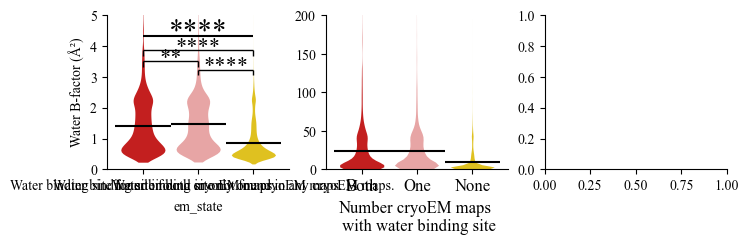

In [72]:
p_overall,p_none_all,p_none_some,p_some_all,mean_2,mean_1,mean_0 = Kruskal_and_mannwhitney(np.array(conB),np.array(nconB),np.array(nonB))

fig,axes = plt.subplots(1,3,figsize=(8,2),sharex=False,sharey=False)

g = sns.violinplot(data=condf, y='mean', x='em_state',
                 palette={"Water binding site found in both cryoEM maps.":h2o_color,
                      "Water binding site found in only one cryoEM maps.":h2o_light_color,
                     "Water binding site not found in any cryoEM maps.":"gold"},
                order = ["Water binding site found in both cryoEM maps.",
                      "Water binding site found in only one cryoEM maps.",
                     "Water binding site not found in any cryoEM maps."],
                       cut=0,scale="width",inner=None,linewidth=0,ax=axes[1])#,ax=ax,orient=orient)
g2 = sns.violinplot(data=rmsfdf, y='mean', x='em_state',
                 palette={"Water binding site found in both cryoEM maps.":h2o_color,
                      "Water binding site found in only one cryoEM maps.":h2o_light_color,
                     "Water binding site not found in any cryoEM maps.":"gold"},
                order = ["Water binding site found in both cryoEM maps.",
                      "Water binding site found in only one cryoEM maps.",
                     "Water binding site not found in any cryoEM maps."],
                       cut=0,scale="width",inner=None,linewidth=0,ax=axes[0])#,ax=ax,orient=orient)
x=g.set_xticklabels( ('Both','One','None'),
                           fontsize=12,rotation=0)
g.hlines(mean_0,-0.5,0.5,"black")
g.hlines(mean_1,0.5,1.5,"black")
g.hlines(mean_2,1.5,2.5,"black")
x=g.set_xlabel("Number cryoEM maps \n with water binding site",size=12)
x=g.set_ylabel("",size=12)
g.set_ylim(0,200)
# TODO mean over bind-sim
p_overall,p_none_all,p_none_some,p_some_all,mean_2,mean_1,mean_0 = Kruskal_and_mannwhitney(np.array(conrmsf_),np.array(nconrmsf_),np.array(nonrmsf))

ax = axes[0]
maxtime=4.5#1.4*300

text_to_add = [get_sig(p) for p in [p_overall,p_none_all,p_none_some,p_some_all]]
sizes = [16 if x!="n.s." else 12 for x in text_to_add]
sizes[0] += 5
x_adjust = [-0.02 if x!="n.s." else 0.02 for x in text_to_add]
ax.text(1,maxtime*(0.96+x_adjust[0]),text_to_add[0],rotation=0,size=sizes[0],ha="center")
ax.hlines(maxtime*0.96,0,2,"black")
ax.text(1,maxtime*(0.86+x_adjust[1]),text_to_add[1],rotation=0,size=sizes[1],ha="center")
ax.hlines(maxtime*0.86,0,2,"black",linewidth=1)
ax.vlines(0,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.vlines(2,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.text(0.5,maxtime*(0.78+x_adjust[3]),text_to_add[3],rotation=0,size=sizes[3],ha="center")
ax.hlines(maxtime*0.78,0,1,"black",linewidth=1)
ax.vlines(0,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.vlines(1,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.text(1.5,maxtime*(0.72+x_adjust[3]),text_to_add[2],rotation=0,size=sizes[2],ha="center")
ax.hlines(maxtime*0.72,1,2,"black",linewidth=1)
ax.vlines(1,maxtime*0.72,maxtime*0.68,"black",linewidth=1)
ax.vlines(2,maxtime*0.72,maxtime*0.68,"black",linewidth=1)
sns.despine()
ax.set_ylabel('Water B-factor (Å²)')
g2.set_ylim(0,5)
g2.hlines(mean_0,-0.5,0.5,"black")
g2.hlines(mean_1,0.5,1.5,"black")
g2.hlines(mean_2,1.5,2.5,"black")
plt.savefig(f"figure_panels/MD_bfactor_water.svg",bbox_inches="tight",transparent=True)
plt.savefig(f"figure_panels/MD_bfactor_water.png", dpi=dpi,bbox_inches="tight",transparent=True)

In [8]:
wat

,other_atom,bind_site,simulation,res_time,atom_types,bind_name,sum_res_time,em_state,occupancy,atoms
0,10020_WAT,371_A_OP,n2ed1,70,OP,A-392:OP,1274,Water binding site not found in any cryoEM maps.,3.192982,OP
1,10020_WAT,371_A_OP,n2ed1,157,OP,A-392:OP,1274,Water binding site not found in any cryoEM maps.,3.192982,OP
2,10020_WAT,371_A_OP,n2ed1,37,OP,A-392:OP,1274,Water binding site not found in any cryoEM maps.,3.192982,OP
3,10020_WAT,371_A_OP,n2ed1,37,OP,A-392:OP,1274,Water binding site not found in any cryoEM maps.,3.192982,OP
4,10020_WAT,371_A_OP,n2ed1,11,OP,A-392:OP,1274,Water binding site not found in any cryoEM maps.,3.192982,OP
...,...,...,...,...,...,...,...,...,...,...
77372,9866_WAT,94_A_OP,n2rn6,11,OP,A-115:OP,125,Water binding site found in only one cryoEM maps.,1.000000,OP
77373,9876_WAT,304_A_OP 305_U_OP,n2rn6,16,"OP,OP",A-325:OP U-326:OP,57,Water binding site not found in any cryoEM maps.,1.000000,OP
77374,9884_WAT,73_A_N1,n2rn6,16,base secondary ketimine,A-94:N1,54,Water binding site not found in any cryoEM maps.,1.000000,Nb
77375,9888_WAT,186_A_OP 241_C_OP,n2rn6,18,"OP,OP",A-207:OP C-262:OP,36,Water binding site not found in any cryoEM maps.,1.000000,OP


In [ ]:
wat

In [110]:
wat_sum --> bind_name, resolved vs not resolved 0.6 --> summary # TODO yes this wil

SyntaxError: invalid syntax (1199874045.py, line 1)

<Axes: xlabel='sum/occ', ylabel='max/sum'>

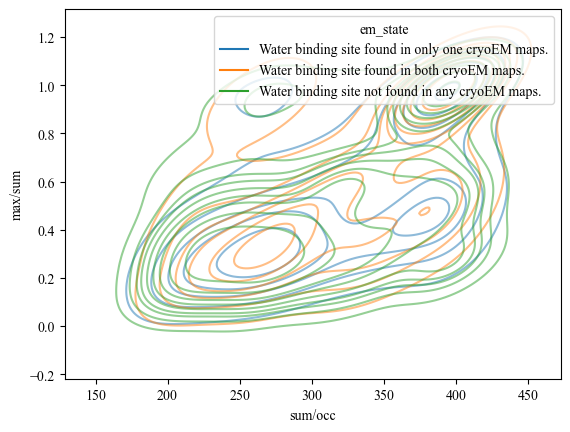

In [8]:
wat_plot = wat.groupby(['bind_name','em_state','occupancy','simulation']).res_time.agg(['mean','sum','max']).reset_index().copy()
wat_plot['sum/occ'] = wat_plot['sum']/wat_plot.occupancy
wat_plot['mean/sum'] = wat_plot.occupancy*wat_plot['mean']/wat_plot['sum']
wat_plot['max/sum'] = wat_plot.occupancy*wat_plot['max']/wat_plot['sum']

Q22 = pd.read_csv('../analysis/per_residue_summary.csv')[['residue_number','Qscore 2.2A']].set_index('residue_number').to_dict()['Qscore 2.2A']
Q23 = pd.read_csv('../analysis/per_residue_summary.csv')[['residue_number','Qscore 2.3A']].set_index('residue_number').to_dict()['Qscore 2.3A']
residues = [[int(bind.split('-')[1].split(':')[0]) for bind in bindspot] for bindspot in wat_plot.bind_name.str.split().to_list()]
Q_bind = [min([max(Q22[bind],Q23[bind]) for bind in bindspot]) for bindspot in residues]
wat_plot['Q_bind'] = Q_bind
wat_plot = wat_plot[wat_plot.Q_bind>=0.6]
sns.kdeplot(data=wat_plot[wat_plot['sum/occ']>200],x='sum/occ',y='max/sum',hue='em_state',alpha=0.5)

Kruskal: 121.67380126866745, p=3.792012483712049e-27
3758 2753 12007
mean 0.644706083723814 0.6328414551864886 0.687163464521621
mannwhitneyu non-all: 24515721.0, p=7.539205747696555e-17
mannwhitneyu non-some: 18248639.5, p=7.3183068079406415e-19
mannwhitneyu some-all: 5081099.5, p=0.21033998712187807
Kruskal: 72.75002422424721, p=1.5941638643105918e-16
538 428 1096
mean 0.5923168103040607 0.530518418081018 0.46089616735791394
mannwhitneyu non-all: 220685.5, p=1.2982815902734066e-16
mannwhitneyu non-some: 201001.5, p=1.3932087841515225e-05
mannwhitneyu some-all: 101724.5, p=0.0018379127436186783


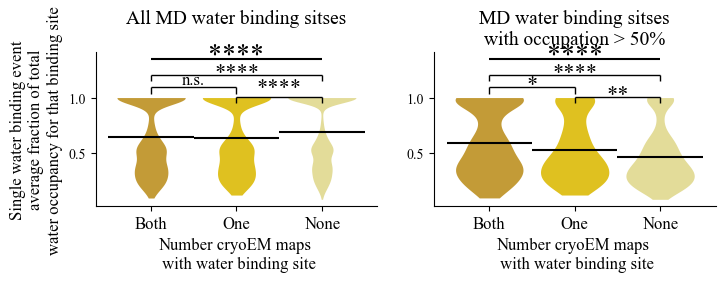

In [68]:
fig,axes = plt.subplots(1,2,figsize=(8,2),sharex=False,sharey=False)
plt.subplots_adjust(hspace=0.1,wspace=0.2)
from scipy import stats

def Kruskal_and_mannwhitney(g1,g2,g3):
    s_overall,p_overall = stats.kruskal(g1,g2,g3, nan_policy='omit')
    print(f"Kruskal: {s_overall}, p={p_overall}")
    print(len(g1),len(g2),len(g3))
    g1 = g1[~np.isnan(g1)]
    g2 = g2[~np.isnan(g2)]
    g3 = g3[~np.isnan(g3)]
    print('mean',g1.mean(),g2.mean(),g3.mean())
    t_none_all, p_none_all = stats.mannwhitneyu(g3, g1)
    print(f"mannwhitneyu non-all: {t_none_all}, p={p_none_all}")
    t_none_some, p_none_some = stats.mannwhitneyu(g3, g2)
    print(f"mannwhitneyu non-some: {t_none_some}, p={p_none_some}")
    t_some_all, p_some_all = stats.mannwhitneyu(g2, g1)
    print(f"mannwhitneyu some-all: {t_some_all}, p={p_some_all}")
    return p_overall,p_none_all,p_none_some,p_some_all,g3.mean(),g2.mean(),g1.mean()

def get_sig(p):
    if p>0.05: sig="n.s."
    elif p>0.0001:  sig="*"
    elif p>0.000001: sig="**"
    elif p>0.00000001: sig="***"
    else: sig="****"
    return sig
g1 = wat_plot[wat_plot.em_state=="Water binding site found in both cryoEM maps."]['max/sum'].values
g2 = wat_plot[wat_plot.em_state=="Water binding site found in only one cryoEM maps."]['max/sum'].values
g3 = wat_plot[wat_plot.em_state=="Water binding site not found in any cryoEM maps."]['max/sum'].values
p_overall,p_none_all,p_none_some,p_some_all,mean_2,mean_1,mean_0 = Kruskal_and_mannwhitney(g1,g2,g3)
    
g = sns.violinplot(data=wat_plot, y='max/sum', x='em_state',ax = axes[0],
                 palette={"Water binding site found in both cryoEM maps.":"goldenrod",
                      "Water binding site found in only one cryoEM maps.":"gold",
                     "Water binding site not found in any cryoEM maps.":"khaki"},
                order = ["Water binding site found in both cryoEM maps.",
                      "Water binding site found in only one cryoEM maps.",
                     "Water binding site not found in any cryoEM maps."],
                       cut=0,scale="width",inner=None,linewidth=0)#,ax=ax,orient=orient)
x=g.set_xticklabels( ('Both','One','None'),
                           fontsize=12,rotation=0)
g.hlines(mean_0,-0.5,0.5,"black")
g.hlines(mean_1,0.5,1.5,"black")
g.hlines(mean_2,1.5,2.5,"black")

axes[0].set_title("All MD water binding sitses\n ",size=14)
x=g.set_xlabel("Number cryoEM maps \n with water binding site",size=12)
x=g.set_ylabel("Single water binding event\naverage fraction of total\nwater occupancy for that binding site",size=12)
#"Average site occupancy (# waters) \nx Average site residence time (ns) \n/ Sum site residence times (ns)",size=12)
axes[1].set_title("MD water binding sitses\nwith occupation > 50%",size=14)
ax = axes[0]
maxtime=1.4
text_to_add = [get_sig(p) for p in [p_overall,p_none_all,p_none_some,p_some_all]]
sizes = [16 if x!="n.s." else 12 for x in text_to_add]
sizes[0] += 4
x_adjust = [-0.02 if x!="n.s." else 0.02 for x in text_to_add]
ax.text(1,maxtime*(0.96+x_adjust[0]),text_to_add[0],rotation=0,size=sizes[0],ha="center")
ax.hlines(maxtime*0.96,0,2,"black")
ax.text(1,maxtime*(0.86+x_adjust[1]),text_to_add[1],rotation=0,size=sizes[1],ha="center")
ax.hlines(maxtime*0.86,0,2,"black",linewidth=1)
ax.vlines(0,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.vlines(2,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.text(0.5,maxtime*(0.78+x_adjust[3]),text_to_add[3],rotation=0,size=sizes[3],ha="center")
ax.hlines(maxtime*0.78,0,1,"black",linewidth=1)
ax.vlines(0,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.vlines(1,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.text(1.5,maxtime*(0.72+x_adjust[3]),text_to_add[2],rotation=0,size=sizes[2],ha="center")
ax.hlines(maxtime*0.72,1,2,"black",linewidth=1)
ax.vlines(1,maxtime*0.72,maxtime*0.68,"black",linewidth=1)
ax.vlines(2,maxtime*0.72,maxtime*0.68,"black",linewidth=1)

wat_sum_200only = wat_plot[wat_plot['sum/occ']>200]
g1 = wat_sum_200only[wat_sum_200only.em_state=="Water binding site found in both cryoEM maps."]['max/sum'].values
g2 = wat_sum_200only[wat_sum_200only.em_state=="Water binding site found in only one cryoEM maps."]['max/sum'].values
g3 = wat_sum_200only[wat_sum_200only.em_state=="Water binding site not found in any cryoEM maps."]['max/sum'].values
p_overall,p_none_all,p_none_some,p_some_all,mean_2,mean_1,mean_0 = Kruskal_and_mannwhitney(g1,g2,g3)
    
g = sns.violinplot(data=wat_sum_200only, y='max/sum', x='em_state',
                 palette={"Water binding site found in both cryoEM maps.":"goldenrod",
                      "Water binding site found in only one cryoEM maps.":"gold",
                     "Water binding site not found in any cryoEM maps.":"khaki"},
                order = ["Water binding site found in both cryoEM maps.",
                      "Water binding site found in only one cryoEM maps.",
                     "Water binding site not found in any cryoEM maps."],
                       cut=0,scale="width",inner=None,linewidth=0,ax=axes[1])#,ax=ax,orient=orient)
x=g.set_xticklabels( ('Both','One','None'),
                           fontsize=12,rotation=0)
g.hlines(mean_0,-0.5,0.5,"black")
g.hlines(mean_1,0.5,1.5,"black")
g.hlines(mean_2,1.5,2.5,"black")
x=g.set_xlabel("Number cryoEM maps \n with water binding site",size=12)
x=g.set_ylabel("",size=12)

ax = axes[1]
maxtime=1.4
text_to_add = [get_sig(p) for p in [p_overall,p_none_all,p_none_some,p_some_all]]
sizes = [16 if x!="n.s." else 12 for x in text_to_add]
sizes[0] += 4
x_adjust = [-0.02 if x!="n.s." else 0.02 for x in text_to_add]
ax.text(1,maxtime*(0.96+x_adjust[0]),text_to_add[0],rotation=0,size=sizes[0],ha="center")
ax.hlines(maxtime*0.96,0,2,"black")
ax.text(1,maxtime*(0.86+x_adjust[1]),text_to_add[1],rotation=0,size=sizes[1],ha="center")
ax.hlines(maxtime*0.86,0,2,"black",linewidth=1)
ax.vlines(0,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.vlines(2,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.text(0.5,maxtime*(0.78+x_adjust[3]),text_to_add[3],rotation=0,size=sizes[3],ha="center")
ax.hlines(maxtime*0.78,0,1,"black",linewidth=1)
ax.vlines(0,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.vlines(1,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.text(1.5,maxtime*(0.72+x_adjust[3]),text_to_add[2],rotation=0,size=sizes[2],ha="center")
ax.hlines(maxtime*0.72,1,2,"black",linewidth=1)
ax.vlines(1,maxtime*0.72,maxtime*0.68,"black",linewidth=1)
ax.vlines(2,maxtime*0.72,maxtime*0.68,"black",linewidth=1)
sns.despine()
plt.savefig(f"figure_panels/residence_time_fractional_binding_sites_max.svg",bbox_inches="tight",transparent=True)
plt.savefig(f"figure_panels/residence_time_fractional_binding_sites_max.png", dpi=dpi,bbox_inches="tight",transparent=True)

Kruskal: 124.60417645616577, p=8.76086264669836e-28
3758 2753 12007
mean 49.28259712613092 47.3265528514348 32.38427583909386
mannwhitneyu non-all: 20513943.0, p=3.500411913033411e-17
mannwhitneyu non-some: 14728988.5, p=3.837733700322913e-19
mannwhitneyu some-all: 5256366.0, p=0.26443006017866966
Kruskal: 79.10446219362083, p=6.647897086627066e-18
538 428 1096
mean 204.81784386617102 179.63317757009347 148.00182481751824
mannwhitneyu non-all: 218577.5, p=1.7880003400884405e-17
mannwhitneyu non-some: 196625.0, p=9.050989582736743e-07
mannwhitneyu some-all: 102636.0, p=0.0037200597777879985


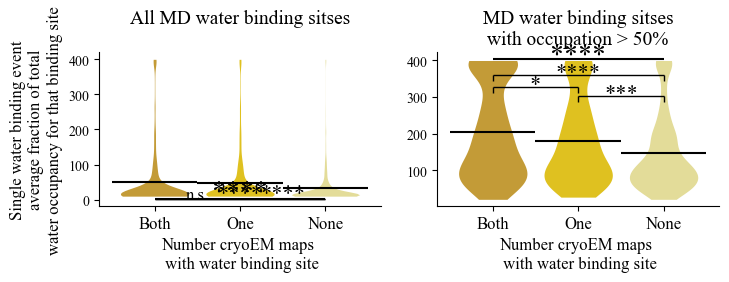

In [69]:
fig,axes = plt.subplots(1,2,figsize=(8,2),sharex=False,sharey=False)
plt.subplots_adjust(hspace=0.1,wspace=0.2)
from scipy import stats

def Kruskal_and_mannwhitney(g1,g2,g3):
    s_overall,p_overall = stats.kruskal(g1,g2,g3, nan_policy='omit')
    print(f"Kruskal: {s_overall}, p={p_overall}")
    print(len(g1),len(g2),len(g3))
    g1 = g1[~np.isnan(g1)]
    g2 = g2[~np.isnan(g2)]
    g3 = g3[~np.isnan(g3)]
    print('mean',g1.mean(),g2.mean(),g3.mean())
    t_none_all, p_none_all = stats.mannwhitneyu(g3, g1)
    print(f"mannwhitneyu non-all: {t_none_all}, p={p_none_all}")
    t_none_some, p_none_some = stats.mannwhitneyu(g3, g2)
    print(f"mannwhitneyu non-some: {t_none_some}, p={p_none_some}")
    t_some_all, p_some_all = stats.mannwhitneyu(g2, g1)
    print(f"mannwhitneyu some-all: {t_some_all}, p={p_some_all}")
    return p_overall,p_none_all,p_none_some,p_some_all,g3.mean(),g2.mean(),g1.mean()

def get_sig(p):
    if p>0.05: sig="n.s."
    elif p>0.0001:  sig="*"
    elif p>0.000001: sig="**"
    elif p>0.00000001: sig="***"
    else: sig="****"
    return sig
g1 = wat_plot[wat_plot.em_state=="Water binding site found in both cryoEM maps."]['max'].values
g2 = wat_plot[wat_plot.em_state=="Water binding site found in only one cryoEM maps."]['max'].values
g3 = wat_plot[wat_plot.em_state=="Water binding site not found in any cryoEM maps."]['max'].values
p_overall,p_none_all,p_none_some,p_some_all,mean_2,mean_1,mean_0 = Kruskal_and_mannwhitney(g1,g2,g3)
    
g = sns.violinplot(data=wat_plot, y='max', x='em_state',ax = axes[0],
                 palette={"Water binding site found in both cryoEM maps.":"goldenrod",
                      "Water binding site found in only one cryoEM maps.":"gold",
                     "Water binding site not found in any cryoEM maps.":"khaki"},
                order = ["Water binding site found in both cryoEM maps.",
                      "Water binding site found in only one cryoEM maps.",
                     "Water binding site not found in any cryoEM maps."],
                       cut=0,scale="width",inner=None,linewidth=0)#,ax=ax,orient=orient)
x=g.set_xticklabels( ('Both','One','None'),
                           fontsize=12,rotation=0)
g.hlines(mean_0,-0.5,0.5,"black")
g.hlines(mean_1,0.5,1.5,"black")
g.hlines(mean_2,1.5,2.5,"black")

axes[0].set_title("All MD water binding sitses\n ",size=14)
x=g.set_xlabel("Number cryoEM maps \n with water binding site",size=12)
x=g.set_ylabel("Single water binding event\naverage fraction of total\nwater occupancy for that binding site",size=12)
#"Average site occupancy (# waters) \nx Average site residence time (ns) \n/ Sum site residence times (ns)",size=12)
axes[1].set_title("MD water binding sitses\nwith occupation > 50%",size=14)
ax = axes[0]
maxtime=1.4
text_to_add = [get_sig(p) for p in [p_overall,p_none_all,p_none_some,p_some_all]]
sizes = [16 if x!="n.s." else 12 for x in text_to_add]
sizes[0] += 4
x_adjust = [-0.02 if x!="n.s." else 0.02 for x in text_to_add]
ax.text(1,maxtime*(0.96+x_adjust[0]),text_to_add[0],rotation=0,size=sizes[0],ha="center")
ax.hlines(maxtime*0.96,0,2,"black")
ax.text(1,maxtime*(0.86+x_adjust[1]),text_to_add[1],rotation=0,size=sizes[1],ha="center")
ax.hlines(maxtime*0.86,0,2,"black",linewidth=1)
ax.vlines(0,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.vlines(2,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.text(0.5,maxtime*(0.78+x_adjust[3]),text_to_add[3],rotation=0,size=sizes[3],ha="center")
ax.hlines(maxtime*0.78,0,1,"black",linewidth=1)
ax.vlines(0,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.vlines(1,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.text(1.5,maxtime*(0.72+x_adjust[3]),text_to_add[2],rotation=0,size=sizes[2],ha="center")
ax.hlines(maxtime*0.72,1,2,"black",linewidth=1)
ax.vlines(1,maxtime*0.72,maxtime*0.68,"black",linewidth=1)
ax.vlines(2,maxtime*0.72,maxtime*0.68,"black",linewidth=1)

wat_sum_200only = wat_plot[wat_plot['sum/occ']>200]
g1 = wat_sum_200only[wat_sum_200only.em_state=="Water binding site found in both cryoEM maps."]['max'].values
g2 = wat_sum_200only[wat_sum_200only.em_state=="Water binding site found in only one cryoEM maps."]['max'].values
g3 = wat_sum_200only[wat_sum_200only.em_state=="Water binding site not found in any cryoEM maps."]['max'].values
p_overall,p_none_all,p_none_some,p_some_all,mean_2,mean_1,mean_0 = Kruskal_and_mannwhitney(g1,g2,g3)
    
g = sns.violinplot(data=wat_sum_200only, y='max', x='em_state',
                 palette={"Water binding site found in both cryoEM maps.":"goldenrod",
                      "Water binding site found in only one cryoEM maps.":"gold",
                     "Water binding site not found in any cryoEM maps.":"khaki"},
                order = ["Water binding site found in both cryoEM maps.",
                      "Water binding site found in only one cryoEM maps.",
                     "Water binding site not found in any cryoEM maps."],
                       cut=0,scale="width",inner=None,linewidth=0,ax=axes[1])#,ax=ax,orient=orient)
x=g.set_xticklabels( ('Both','One','None'),
                           fontsize=12,rotation=0)
g.hlines(mean_0,-0.5,0.5,"black")
g.hlines(mean_1,0.5,1.5,"black")
g.hlines(mean_2,1.5,2.5,"black")
x=g.set_xlabel("Number cryoEM maps \n with water binding site",size=12)
x=g.set_ylabel("",size=12)

ax = axes[1]
maxtime=1.4*300
text_to_add = [get_sig(p) for p in [p_overall,p_none_all,p_none_some,p_some_all]]
sizes = [16 if x!="n.s." else 12 for x in text_to_add]
sizes[0] += 4
x_adjust = [-0.02 if x!="n.s." else 0.02 for x in text_to_add]
ax.text(1,maxtime*(0.96+x_adjust[0]),text_to_add[0],rotation=0,size=sizes[0],ha="center")
ax.hlines(maxtime*0.96,0,2,"black")
ax.text(1,maxtime*(0.86+x_adjust[1]),text_to_add[1],rotation=0,size=sizes[1],ha="center")
ax.hlines(maxtime*0.86,0,2,"black",linewidth=1)
ax.vlines(0,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.vlines(2,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.text(0.5,maxtime*(0.78+x_adjust[3]),text_to_add[3],rotation=0,size=sizes[3],ha="center")
ax.hlines(maxtime*0.78,0,1,"black",linewidth=1)
ax.vlines(0,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.vlines(1,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.text(1.5,maxtime*(0.72+x_adjust[3]),text_to_add[2],rotation=0,size=sizes[2],ha="center")
ax.hlines(maxtime*0.72,1,2,"black",linewidth=1)
ax.vlines(1,maxtime*0.72,maxtime*0.68,"black",linewidth=1)
ax.vlines(2,maxtime*0.72,maxtime*0.68,"black",linewidth=1)
sns.despine()
plt.savefig(f"figure_panels/residence_time_fractional_binding_sites_max_time.svg",bbox_inches="tight",transparent=True)
plt.savefig(f"figure_panels/residence_time_fractional_binding_sites_max_time.png", dpi=dpi,bbox_inches="tight",transparent=True)

9480.199366562934
Kruskal: 33.53871738452936, p=5.2138682760875514e-08
378 360 3840
mean 20.731211530172953 20.22558763007061 17.527699982476438
mannwhitneyu non-all: 619027.5, p=2.2417061144695726e-06
mannwhitneyu non-some: 608928.0, p=0.0001807172587070162
mannwhitneyu some-all: 66196.5, p=0.5242651975777962
Kruskal: 1.1524061413932094, p=0.5620283021288337
180 149 822
mean 28.723062775955288 29.788734084968137 29.41876494764766
mannwhitneyu non-all: 77572.0, p=0.3071227615565393
mannwhitneyu non-some: 60273.0, p=0.7591969291192313
mannwhitneyu some-all: 14081.0, p=0.43495881241476997


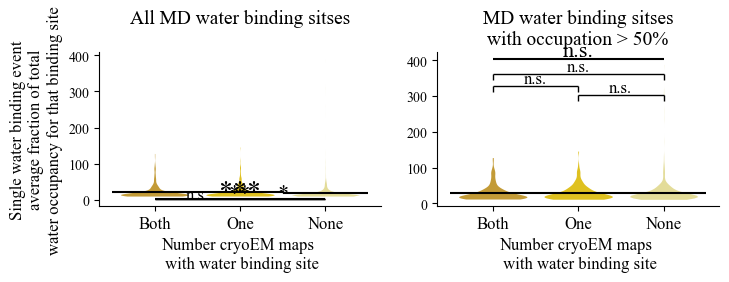

In [65]:
fig,axes = plt.subplots(1,2,figsize=(8,2),sharex=False,sharey=False)
plt.subplots_adjust(hspace=0.1,wspace=0.2)
from scipy import stats

def Kruskal_and_mannwhitney(g1,g2,g3):
    s_overall,p_overall = stats.kruskal(g1,g2,g3, nan_policy='omit')
    print(f"Kruskal: {s_overall}, p={p_overall}")
    print(len(g1),len(g2),len(g3))
    g1 = g1[~np.isnan(g1)]
    g2 = g2[~np.isnan(g2)]
    g3 = g3[~np.isnan(g3)]
    print('mean',g1.mean(),g2.mean(),g3.mean())
    t_none_all, p_none_all = stats.mannwhitneyu(g3, g1)
    print(f"mannwhitneyu non-all: {t_none_all}, p={p_none_all}")
    t_none_some, p_none_some = stats.mannwhitneyu(g3, g2)
    print(f"mannwhitneyu non-some: {t_none_some}, p={p_none_some}")
    t_some_all, p_some_all = stats.mannwhitneyu(g2, g1)
    print(f"mannwhitneyu some-all: {t_some_all}, p={p_some_all}")
    return p_overall,p_none_all,p_none_some,p_some_all,g3.mean(),g2.mean(),g1.mean()

def get_sig(p):
    if p>0.05: sig="n.s."
    elif p>0.0001:  sig="*"
    elif p>0.000001: sig="**"
    elif p>0.00000001: sig="***"
    else: sig="****"
    return sig
wat_plot = wat.groupby(['bind_name','em_state'])[['res_time','occupancy']].agg(['mean','sum','max']).reset_index().copy()
wat_plot['sum/occ'] = wat_plot.res_time['sum']/wat_plot.occupancy['mean']
print(wat_plot['sum/occ'].max())
#wat_plot['mean']=wat_plot.res_time['mean']
wat_plot['mean']=wat_plot.res_time['mean']

g1 = wat_plot[wat_plot.em_state=="Water binding site found in both cryoEM maps."]['mean'].values
g2 = wat_plot[wat_plot.em_state=="Water binding site found in only one cryoEM maps."]['mean'].values
g3 = wat_plot[wat_plot.em_state=="Water binding site not found in any cryoEM maps."]['mean'].values
p_overall,p_none_all,p_none_some,p_some_all,mean_2,mean_1,mean_0 = Kruskal_and_mannwhitney(g1,g2,g3)
    
g = sns.violinplot(data=wat_plot, y='mean', x='em_state',ax = axes[0],
                 palette={"Water binding site found in both cryoEM maps.":"goldenrod",
                      "Water binding site found in only one cryoEM maps.":"gold",
                     "Water binding site not found in any cryoEM maps.":"khaki"},
                order = ["Water binding site found in both cryoEM maps.",
                      "Water binding site found in only one cryoEM maps.",
                     "Water binding site not found in any cryoEM maps."],
                       cut=0,scale="width",inner=None,linewidth=0)#,ax=ax,orient=orient)
x=g.set_xticklabels( ('Both','One','None'),
                           fontsize=12,rotation=0)
g.hlines(mean_0,-0.5,0.5,"black")
g.hlines(mean_1,0.5,1.5,"black")
g.hlines(mean_2,1.5,2.5,"black")

axes[0].set_title("All MD water binding sitses\n ",size=14)
x=g.set_xlabel("Number cryoEM maps \n with water binding site",size=12)
x=g.set_ylabel("Single water binding event\naverage fraction of total\nwater occupancy for that binding site",size=12)
#"Average site occupancy (# waters) \nx Average site residence time (ns) \n/ Sum site residence times (ns)",size=12)
axes[1].set_title("MD water binding sitses\nwith occupation > 50%",size=14)
ax = axes[0]
maxtime=1.4
text_to_add = [get_sig(p) for p in [p_overall,p_none_all,p_none_some,p_some_all]]
sizes = [16 if x!="n.s." else 12 for x in text_to_add]
sizes[0] += 4
x_adjust = [-0.02 if x!="n.s." else 0.02 for x in text_to_add]
ax.text(1,maxtime*(0.96+x_adjust[0]),text_to_add[0],rotation=0,size=sizes[0],ha="center")
ax.hlines(maxtime*0.96,0,2,"black")
ax.text(1,maxtime*(0.86+x_adjust[1]),text_to_add[1],rotation=0,size=sizes[1],ha="center")
ax.hlines(maxtime*0.86,0,2,"black",linewidth=1)
ax.vlines(0,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.vlines(2,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.text(0.5,maxtime*(0.78+x_adjust[3]),text_to_add[3],rotation=0,size=sizes[3],ha="center")
ax.hlines(maxtime*0.78,0,1,"black",linewidth=1)
ax.vlines(0,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.vlines(1,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.text(1.5,maxtime*(0.72+x_adjust[3]),text_to_add[2],rotation=0,size=sizes[2],ha="center")
ax.hlines(maxtime*0.72,1,2,"black",linewidth=1)
ax.vlines(1,maxtime*0.72,maxtime*0.68,"black",linewidth=1)
ax.vlines(2,maxtime*0.72,maxtime*0.68,"black",linewidth=1)

wat_sum_200only = wat_plot[wat_plot['sum/occ']>200]
g1 = wat_sum_200only[wat_sum_200only.em_state=="Water binding site found in both cryoEM maps."]['mean'].values
g2 = wat_sum_200only[wat_sum_200only.em_state=="Water binding site found in only one cryoEM maps."]['mean'].values
g3 = wat_sum_200only[wat_sum_200only.em_state=="Water binding site not found in any cryoEM maps."]['mean'].values
p_overall,p_none_all,p_none_some,p_some_all,mean_2,mean_1,mean_0 = Kruskal_and_mannwhitney(g1,g2,g3)
    
g = sns.violinplot(data=wat_sum_200only, y='mean', x='em_state',
                 palette={"Water binding site found in both cryoEM maps.":"goldenrod",
                      "Water binding site found in only one cryoEM maps.":"gold",
                     "Water binding site not found in any cryoEM maps.":"khaki"},
                order = ["Water binding site found in both cryoEM maps.",
                      "Water binding site found in only one cryoEM maps.",
                     "Water binding site not found in any cryoEM maps."],
                       cut=0,scale="width",inner=None,linewidth=0,ax=axes[1])#,ax=ax,orient=orient)
x=g.set_xticklabels( ('Both','One','None'),
                           fontsize=12,rotation=0)
g.hlines(mean_0,-0.5,0.5,"black")
g.hlines(mean_1,0.5,1.5,"black")
g.hlines(mean_2,1.5,2.5,"black")
x=g.set_xlabel("Number cryoEM maps \n with water binding site",size=12)
x=g.set_ylabel("",size=12)

ax = axes[1]
maxtime=1.4*300
text_to_add = [get_sig(p) for p in [p_overall,p_none_all,p_none_some,p_some_all]]
sizes = [16 if x!="n.s." else 12 for x in text_to_add]
sizes[0] += 4
x_adjust = [-0.02 if x!="n.s." else 0.02 for x in text_to_add]
ax.text(1,maxtime*(0.96+x_adjust[0]),text_to_add[0],rotation=0,size=sizes[0],ha="center")
ax.hlines(maxtime*0.96,0,2,"black")
ax.text(1,maxtime*(0.86+x_adjust[1]),text_to_add[1],rotation=0,size=sizes[1],ha="center")
ax.hlines(maxtime*0.86,0,2,"black",linewidth=1)
ax.vlines(0,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.vlines(2,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.text(0.5,maxtime*(0.78+x_adjust[3]),text_to_add[3],rotation=0,size=sizes[3],ha="center")
ax.hlines(maxtime*0.78,0,1,"black",linewidth=1)
ax.vlines(0,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.vlines(1,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.text(1.5,maxtime*(0.72+x_adjust[3]),text_to_add[2],rotation=0,size=sizes[2],ha="center")
ax.hlines(maxtime*0.72,1,2,"black",linewidth=1)
ax.vlines(1,maxtime*0.72,maxtime*0.68,"black",linewidth=1)
ax.vlines(2,maxtime*0.72,maxtime*0.68,"black",linewidth=1)
sns.despine()
plt.savefig(f"figure_panels/residence_time_fractional_binding_sites_mean_time.svg",bbox_inches="tight",transparent=True)
plt.savefig(f"figure_panels/residence_time_fractional_binding_sites_mean_time.png", dpi=dpi,bbox_inches="tight",transparent=True)

In [79]:
order = list(wat_sum_200only.groupby('bind_name')['mean'].mean().sort_values(ascending=False).index)
wat_sum_200only['bindsim'] = wat_sum_200only['bind_name']+wat_sum_200only['simulation']
good = wat_sum_200only['bindsim'].to_list()

C:\Users\racha\AppData\Local\Temp\ipykernel_34712\3656964610.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wat_sum_200only['bindsim'] = wat_sum_200only['bind_name']+wat_sum_200only['simulation']


In [82]:
wat['bindsim'] = wat['bind_name']+wat['simulation']
wat_good = wat[wat['bindsim'].isin(good)]

<Axes: xlabel='bind_name', ylabel='res_time'>

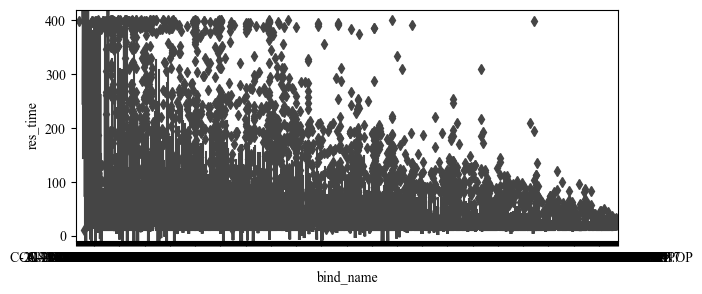

In [94]:
fig,ax=plt.subplots(1,figsize=(7,3))

sns.boxplot(data=wat_good,x='bind_name',y='res_time',order=order,notch=True, showcaps=False,ax=ax)

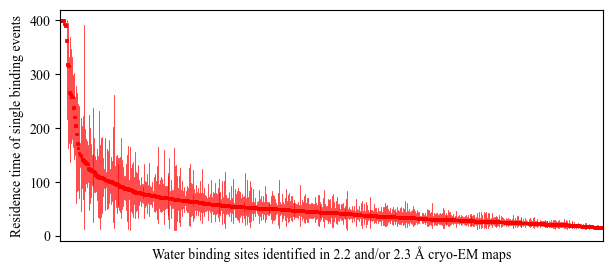

In [104]:
fig,ax=plt.subplots(1,figsize=(7,3))
order = list(wat_good.groupby('bind_name')['res_time'].mean().sort_values(ascending=False).index)

sns.pointplot(data=wat_good,x='bind_name',y='res_time',order=order,join=False,ax=ax,errwidth=0.5,markers=[','],scale=0.3,palette=['#ff0000'])
ax.set_ylabel('Residence time of single binding events')
ax.set_xlabel('Water binding sites identified in 2.2 and/or 2.3 Å cryo-EM maps')
ax.set_xticks([])
plt.savefig(f"figure_panels/residence_time_mean_time.svg",bbox_inches="tight",transparent=True)
plt.savefig(f"figure_panels/residence_time_mean_time.png", dpi=dpi,bbox_inches="tight",transparent=True)

In [ ]:
wat_sum_200only = wat.groupby(['bind_name','em_state','occupancy','simulation']).res_time.agg(['mean','sum']).reset_index().copy()
wat_sum_200only = wat_sum_200only[(wat_sum_200only['sum']/wat_sum_200only.occupancy)>200]
# and then also the line plot above
#wat_sum_200only = wat_sum_200only[(wat_sum_200only['mean'])<11]

wat_sum_200only['mean/sum'] = wat_sum_200only.occupancy*wat_sum_200only['mean']/wat_sum_200only['sum']


g1 = wat_sum_200only[wat_sum_200only.em_state=="Water binding site found in both cryoEM maps."]['mean/sum'].values
g2 = wat_sum_200only[wat_sum_200only.em_state=="Water binding site found in only one cryoEM maps."]['mean/sum'].values
g3 = wat_sum_200only[wat_sum_200only.em_state=="Water binding site not found in any cryoEM maps."]['mean/sum'].values
p_overall,p_none_all,p_none_some,p_some_all,mean_2,mean_1,mean_0 = Kruskal_and_mannwhitney(g1,g2,g3)
  

Kruskal: 242.33295298040966, p=2.38818446328694e-53
3758 2786 14233
mean 0.5396763225148763 0.5336616791010866 0.6186291975011515
mannwhitneyu non-all: 30077198.0, p=1.3277089196620036e-34
mannwhitneyu non-some: 22503060.5, p=5.211759707427084e-32
mannwhitneyu some-all: 5179779.0, p=0.4557306686041125
Kruskal: 20.189008044802602, p=4.130594909854492e-05
538 435 1324
mean 0.2759937600873983 0.26449311454304936 0.22386521157255065
mannwhitneyu non-all: 311977.0, p=2.6489168666474925e-05
mannwhitneyu non-some: 263379.0, p=0.007450323791340647
mannwhitneyu some-all: 112818.5, p=0.33558959188945503


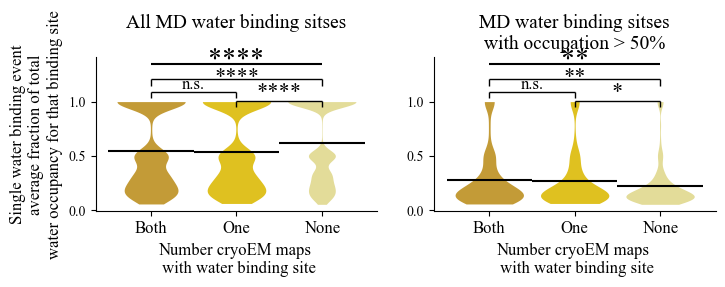

In [6]:
wat_sum['mean/sum'] = wat_sum.occupancy*wat_sum['mean']/wat_sum['sum']
from scipy import stats

def Kruskal_and_mannwhitney(g1,g2,g3):
    s_overall,p_overall = stats.kruskal(g1,g2,g3, nan_policy='omit')
    print(f"Kruskal: {s_overall}, p={p_overall}")
    print(len(g1),len(g2),len(g3))
    g1 = g1[~np.isnan(g1)]
    g2 = g2[~np.isnan(g2)]
    g3 = g3[~np.isnan(g3)]
    print('mean',g1.mean(),g2.mean(),g3.mean())
    t_none_all, p_none_all = stats.mannwhitneyu(g3, g1)
    print(f"mannwhitneyu non-all: {t_none_all}, p={p_none_all}")
    t_none_some, p_none_some = stats.mannwhitneyu(g3, g2)
    print(f"mannwhitneyu non-some: {t_none_some}, p={p_none_some}")
    t_some_all, p_some_all = stats.mannwhitneyu(g2, g1)
    print(f"mannwhitneyu some-all: {t_some_all}, p={p_some_all}")
    return p_overall,p_none_all,p_none_some,p_some_all,g3.mean(),g2.mean(),g1.mean()

def get_sig(p):
    if p>0.05: sig="n.s."
    elif p>0.0001:  sig="*"
    elif p>0.000001: sig="**"
    elif p>0.00000001: sig="***"
    else: sig="****"
    return sig

fig,axes = plt.subplots(1,2,figsize=(8,2),sharex=False,sharey=False)
plt.subplots_adjust(hspace=0.1,wspace=0.2)

g1 = wat_sum[wat_sum.em_state=="Water binding site found in both cryoEM maps."]['mean/sum'].values
g2 = wat_sum[wat_sum.em_state=="Water binding site found in only one cryoEM maps."]['mean/sum'].values
g3 = wat_sum[wat_sum.em_state=="Water binding site not found in any cryoEM maps."]['mean/sum'].values
p_overall,p_none_all,p_none_some,p_some_all,mean_2,mean_1,mean_0 = Kruskal_and_mannwhitney(g1,g2,g3)
    
g = sns.violinplot(data=wat_sum, y='mean/sum', x='em_state',ax = axes[0],
                 palette={"Water binding site found in both cryoEM maps.":"goldenrod",
                      "Water binding site found in only one cryoEM maps.":"gold",
                     "Water binding site not found in any cryoEM maps.":"khaki"},
                order = ["Water binding site found in both cryoEM maps.",
                      "Water binding site found in only one cryoEM maps.",
                     "Water binding site not found in any cryoEM maps."],
                       cut=0,scale="width",inner=None,linewidth=0)#,ax=ax,orient=orient)
x=g.set_xticklabels( ('Both','One','None'),
                           fontsize=12,rotation=0)
g.hlines(mean_0,-0.5,0.5,"black")
g.hlines(mean_1,0.5,1.5,"black")
g.hlines(mean_2,1.5,2.5,"black")

axes[0].set_title("All MD water binding sitses\n ",size=14)
x=g.set_xlabel("Number cryoEM maps \n with water binding site",size=12)
x=g.set_ylabel("Single water binding event\naverage fraction of total\nwater occupancy for that binding site",size=12)
#"Average site occupancy (# waters) \nx Average site residence time (ns) \n/ Sum site residence times (ns)",size=12)
axes[1].set_title("MD water binding sitses\nwith occupation > 50%",size=14)
ax = axes[0]
maxtime=1.4
text_to_add = [get_sig(p) for p in [p_overall,p_none_all,p_none_some,p_some_all]]
sizes = [16 if x!="n.s." else 12 for x in text_to_add]
sizes[0] += 4
x_adjust = [-0.02 if x!="n.s." else 0.02 for x in text_to_add]
ax.text(1,maxtime*(0.96+x_adjust[0]),text_to_add[0],rotation=0,size=sizes[0],ha="center")
ax.hlines(maxtime*0.96,0,2,"black")
ax.text(1,maxtime*(0.86+x_adjust[1]),text_to_add[1],rotation=0,size=sizes[1],ha="center")
ax.hlines(maxtime*0.86,0,2,"black",linewidth=1)
ax.vlines(0,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.vlines(2,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.text(0.5,maxtime*(0.78+x_adjust[3]),text_to_add[3],rotation=0,size=sizes[3],ha="center")
ax.hlines(maxtime*0.78,0,1,"black",linewidth=1)
ax.vlines(0,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.vlines(1,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.text(1.5,maxtime*(0.72+x_adjust[3]),text_to_add[2],rotation=0,size=sizes[2],ha="center")
ax.hlines(maxtime*0.72,1,2,"black",linewidth=1)
ax.vlines(1,maxtime*0.72,maxtime*0.68,"black",linewidth=1)
ax.vlines(2,maxtime*0.72,maxtime*0.68,"black",linewidth=1)


wat_sum_200only = wat.groupby(['bind_name','em_state','occupancy','simulation']).res_time.agg(['mean','sum']).reset_index().copy()
wat_sum_200only = wat_sum_200only[(wat_sum_200only['sum']/wat_sum_200only.occupancy)>200]
# and then also the line plot above
#wat_sum_200only = wat_sum_200only[(wat_sum_200only['mean'])<11]

wat_sum_200only['mean/sum'] = wat_sum_200only.occupancy*wat_sum_200only['mean']/wat_sum_200only['sum']


g1 = wat_sum_200only[wat_sum_200only.em_state=="Water binding site found in both cryoEM maps."]['mean/sum'].values
g2 = wat_sum_200only[wat_sum_200only.em_state=="Water binding site found in only one cryoEM maps."]['mean/sum'].values
g3 = wat_sum_200only[wat_sum_200only.em_state=="Water binding site not found in any cryoEM maps."]['mean/sum'].values
p_overall,p_none_all,p_none_some,p_some_all,mean_2,mean_1,mean_0 = Kruskal_and_mannwhitney(g1,g2,g3)
    
g = sns.violinplot(data=wat_sum_200only, y='mean/sum', x='em_state',
                 palette={"Water binding site found in both cryoEM maps.":"goldenrod",
                      "Water binding site found in only one cryoEM maps.":"gold",
                     "Water binding site not found in any cryoEM maps.":"khaki"},
                order = ["Water binding site found in both cryoEM maps.",
                      "Water binding site found in only one cryoEM maps.",
                     "Water binding site not found in any cryoEM maps."],
                       cut=0,scale="width",inner=None,linewidth=0,ax=axes[1])#,ax=ax,orient=orient)
x=g.set_xticklabels( ('Both','One','None'),
                           fontsize=12,rotation=0)
g.hlines(mean_0,-0.5,0.5,"black")
g.hlines(mean_1,0.5,1.5,"black")
g.hlines(mean_2,1.5,2.5,"black")
x=g.set_xlabel("Number cryoEM maps \n with water binding site",size=12)
x=g.set_ylabel("",size=12)

ax = axes[1]
maxtime=1.4
text_to_add = [get_sig(p) for p in [p_overall,p_none_all,p_none_some,p_some_all]]
sizes = [16 if x!="n.s." else 12 for x in text_to_add]
sizes[0] += 4
x_adjust = [-0.02 if x!="n.s." else 0.02 for x in text_to_add]
ax.text(1,maxtime*(0.96+x_adjust[0]),text_to_add[0],rotation=0,size=sizes[0],ha="center")
ax.hlines(maxtime*0.96,0,2,"black")
ax.text(1,maxtime*(0.86+x_adjust[1]),text_to_add[1],rotation=0,size=sizes[1],ha="center")
ax.hlines(maxtime*0.86,0,2,"black",linewidth=1)
ax.vlines(0,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.vlines(2,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.text(0.5,maxtime*(0.78+x_adjust[3]),text_to_add[3],rotation=0,size=sizes[3],ha="center")
ax.hlines(maxtime*0.78,0,1,"black",linewidth=1)
ax.vlines(0,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.vlines(1,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.text(1.5,maxtime*(0.72+x_adjust[3]),text_to_add[2],rotation=0,size=sizes[2],ha="center")
ax.hlines(maxtime*0.72,1,2,"black",linewidth=1)
ax.vlines(1,maxtime*0.72,maxtime*0.68,"black",linewidth=1)
ax.vlines(2,maxtime*0.72,maxtime*0.68,"black",linewidth=1)
sns.despine()
plt.savefig(f"figure_panels/residence_time_fractional_binding_sites.svg",bbox_inches="tight",transparent=True)
plt.savefig(f"figure_panels/residence_time_fractional_binding_sites.png", dpi=dpi,bbox_inches="tight",transparent=True)
# because both enriched in high occupancy spots, lowest occupancy actually have 1 excahnge rate --> mroe none
# pattern swapped after
# TODO plot water bind spots so it fits 2 rows  as above by 6 (4,8)

Kruskal: 242.33295298040966, p=2.38818446328694e-53
3758 2786 14233
mean 0.5396763225148763 0.5336616791010866 0.6186291975011515
mannwhitneyu non-all: 30077198.0, p=1.3277089196620036e-34
mannwhitneyu non-some: 22503060.5, p=5.211759707427084e-32
mannwhitneyu some-all: 5179779.0, p=0.4557306686041125
20777
12260
Kruskal: 54.84746872041446, p=1.230335326895187e-12
2462 1846 7952
mean 0.2973613403781093 0.2961979620669704 0.31739805936039855
mannwhitneyu non-all: 10541344.0, p=5.0806793958410266e-09
mannwhitneyu non-some: 7954854.5, p=1.2466663292640353e-08
mannwhitneyu some-all: 2256379.0, p=0.6891400923314512
Kruskal: 20.189008044802602, p=4.130594909854492e-05
538 435 1324
mean 0.2759937600873983 0.26449311454304936 0.22386521157255065
mannwhitneyu non-all: 311977.0, p=2.6489168666474925e-05
mannwhitneyu non-some: 263379.0, p=0.007450323791340647
mannwhitneyu some-all: 112818.5, p=0.33558959188945503


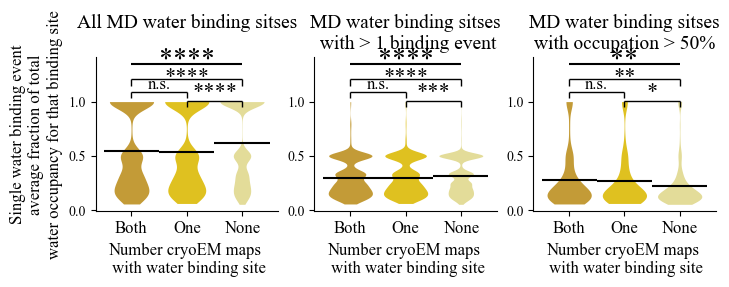

In [12]:
wat_sum['mean/sum'] = wat_sum.occupancy*wat_sum['mean']/wat_sum['sum']
from scipy import stats

def Kruskal_and_mannwhitney(g1,g2,g3):
    s_overall,p_overall = stats.kruskal(g1,g2,g3, nan_policy='omit')
    print(f"Kruskal: {s_overall}, p={p_overall}")
    print(len(g1),len(g2),len(g3))
    g1 = g1[~np.isnan(g1)]
    g2 = g2[~np.isnan(g2)]
    g3 = g3[~np.isnan(g3)]
    print('mean',g1.mean(),g2.mean(),g3.mean())
    t_none_all, p_none_all = stats.mannwhitneyu(g3, g1)
    print(f"mannwhitneyu non-all: {t_none_all}, p={p_none_all}")
    t_none_some, p_none_some = stats.mannwhitneyu(g3, g2)
    print(f"mannwhitneyu non-some: {t_none_some}, p={p_none_some}")
    t_some_all, p_some_all = stats.mannwhitneyu(g2, g1)
    print(f"mannwhitneyu some-all: {t_some_all}, p={p_some_all}")
    return p_overall,p_none_all,p_none_some,p_some_all,g3.mean(),g2.mean(),g1.mean()

def get_sig(p):
    if p>0.05: sig="n.s."
    elif p>0.0001:  sig="*"
    elif p>0.000001: sig="**"
    elif p>0.00000001: sig="***"
    else: sig="****"
    return sig

fig,axes = plt.subplots(1,3,figsize=(8,2),sharex=False,sharey=False)
plt.subplots_adjust(hspace=0.1,wspace=0.2)

g1 = wat_sum[wat_sum.em_state=="Water binding site found in both cryoEM maps."]['mean/sum'].values
g2 = wat_sum[wat_sum.em_state=="Water binding site found in only one cryoEM maps."]['mean/sum'].values
g3 = wat_sum[wat_sum.em_state=="Water binding site not found in any cryoEM maps."]['mean/sum'].values
p_overall,p_none_all,p_none_some,p_some_all,mean_2,mean_1,mean_0 = Kruskal_and_mannwhitney(g1,g2,g3)
    
g = sns.violinplot(data=wat_sum, y='mean/sum', x='em_state',ax = axes[0],
                 palette={"Water binding site found in both cryoEM maps.":"goldenrod",
                      "Water binding site found in only one cryoEM maps.":"gold",
                     "Water binding site not found in any cryoEM maps.":"khaki"},
                order = ["Water binding site found in both cryoEM maps.",
                      "Water binding site found in only one cryoEM maps.",
                     "Water binding site not found in any cryoEM maps."],
                       cut=0,scale="width",inner=None,linewidth=0)#,ax=ax,orient=orient)
x=g.set_xticklabels( ('Both','One','None'),
                           fontsize=12,rotation=0)
g.hlines(mean_0,-0.5,0.5,"black")
g.hlines(mean_1,0.5,1.5,"black")
g.hlines(mean_2,1.5,2.5,"black")

axes[0].set_title("All MD water binding sitses\n ",size=14)
x=g.set_xlabel("Number cryoEM maps \n with water binding site",size=12)
x=g.set_ylabel("Single water binding event\naverage fraction of total\nwater occupancy for that binding site",size=12)
#"Average site occupancy (# waters) \nx Average site residence time (ns) \n/ Sum site residence times (ns)",size=12)
axes[1].set_title("MD water binding sitses\n with > 1 binding event",size=14)
axes[2].set_title("MD water binding sitses\nwith occupation > 50%",size=14)
ax = axes[0]
maxtime=1.4
text_to_add = [get_sig(p) for p in [p_overall,p_none_all,p_none_some,p_some_all]]
sizes = [16 if x!="n.s." else 12 for x in text_to_add]
sizes[0] += 4
x_adjust = [-0.02 if x!="n.s." else 0.02 for x in text_to_add]
ax.text(1,maxtime*(0.96+x_adjust[0]),text_to_add[0],rotation=0,size=sizes[0],ha="center")
ax.hlines(maxtime*0.96,0,2,"black")
ax.text(1,maxtime*(0.86+x_adjust[1]),text_to_add[1],rotation=0,size=sizes[1],ha="center")
ax.hlines(maxtime*0.86,0,2,"black",linewidth=1)
ax.vlines(0,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.vlines(2,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.text(0.5,maxtime*(0.78+x_adjust[3]),text_to_add[3],rotation=0,size=sizes[3],ha="center")
ax.hlines(maxtime*0.78,0,1,"black",linewidth=1)
ax.vlines(0,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.vlines(1,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.text(1.5,maxtime*(0.72+x_adjust[3]),text_to_add[2],rotation=0,size=sizes[2],ha="center")
ax.hlines(maxtime*0.72,1,2,"black",linewidth=1)
ax.vlines(1,maxtime*0.72,maxtime*0.68,"black",linewidth=1)
ax.vlines(2,maxtime*0.72,maxtime*0.68,"black",linewidth=1)

wat_sum_200only = wat.groupby(['bind_name','em_state','occupancy','simulation']).res_time.agg(['mean','sum']).reset_index().copy()
#wat_sum_200only = wat_sum_200only[(wat_sum_200only['sum']/wat_sum_200only.occupancy)>200]
print(len(wat_sum_200only))
wat_sum_200only = wat_sum_200only[wat_sum_200only['sum']!=wat_sum_200only['mean']]
print(len(wat_sum_200only))
# TODO plot both of these
# and then also the line plot above
#wat_sum_200only = wat_sum_200only[(wat_sum_200only['mean'])<11]

wat_sum_200only['mean/sum'] = wat_sum_200only.occupancy*wat_sum_200only['mean']/wat_sum_200only['sum']


g1 = wat_sum_200only[wat_sum_200only.em_state=="Water binding site found in both cryoEM maps."]['mean/sum'].values
g2 = wat_sum_200only[wat_sum_200only.em_state=="Water binding site found in only one cryoEM maps."]['mean/sum'].values
g3 = wat_sum_200only[wat_sum_200only.em_state=="Water binding site not found in any cryoEM maps."]['mean/sum'].values
p_overall,p_none_all,p_none_some,p_some_all,mean_2,mean_1,mean_0 = Kruskal_and_mannwhitney(g1,g2,g3)
    
g = sns.violinplot(data=wat_sum_200only, y='mean/sum', x='em_state',
                 palette={"Water binding site found in both cryoEM maps.":"goldenrod",
                      "Water binding site found in only one cryoEM maps.":"gold",
                     "Water binding site not found in any cryoEM maps.":"khaki"},
                order = ["Water binding site found in both cryoEM maps.",
                      "Water binding site found in only one cryoEM maps.",
                     "Water binding site not found in any cryoEM maps."],
                       cut=0,scale="width",inner=None,linewidth=0,ax=axes[1])#,ax=ax,orient=orient)
x=g.set_xticklabels( ('Both','One','None'),
                           fontsize=12,rotation=0)
g.hlines(mean_0,-0.5,0.5,"black")
g.hlines(mean_1,0.5,1.5,"black")
g.hlines(mean_2,1.5,2.5,"black")
x=g.set_xlabel("Number cryoEM maps \n with water binding site",size=12)
x=g.set_ylabel("",size=12)

ax = axes[1]
maxtime=1.4
text_to_add = [get_sig(p) for p in [p_overall,p_none_all,p_none_some,p_some_all]]
sizes = [16 if x!="n.s." else 12 for x in text_to_add]
sizes[0] += 4
x_adjust = [-0.02 if x!="n.s." else 0.02 for x in text_to_add]
ax.text(1,maxtime*(0.96+x_adjust[0]),text_to_add[0],rotation=0,size=sizes[0],ha="center")
ax.hlines(maxtime*0.96,0,2,"black")
ax.text(1,maxtime*(0.86+x_adjust[1]),text_to_add[1],rotation=0,size=sizes[1],ha="center")
ax.hlines(maxtime*0.86,0,2,"black",linewidth=1)
ax.vlines(0,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.vlines(2,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.text(0.5,maxtime*(0.78+x_adjust[3]),text_to_add[3],rotation=0,size=sizes[3],ha="center")
ax.hlines(maxtime*0.78,0,1,"black",linewidth=1)
ax.vlines(0,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.vlines(1,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.text(1.5,maxtime*(0.72+x_adjust[3]),text_to_add[2],rotation=0,size=sizes[2],ha="center")
ax.hlines(maxtime*0.72,1,2,"black",linewidth=1)
ax.vlines(1,maxtime*0.72,maxtime*0.68,"black",linewidth=1)
ax.vlines(2,maxtime*0.72,maxtime*0.68,"black",linewidth=1)


wat_sum_200only = wat.groupby(['bind_name','em_state','occupancy','simulation']).res_time.agg(['mean','sum']).reset_index().copy()
wat_sum_200only = wat_sum_200only[(wat_sum_200only['sum']/wat_sum_200only.occupancy)>200]
# and then also the line plot above
#wat_sum_200only = wat_sum_200only[(wat_sum_200only['mean'])<11]

wat_sum_200only['mean/sum'] = wat_sum_200only.occupancy*wat_sum_200only['mean']/wat_sum_200only['sum']


g1 = wat_sum_200only[wat_sum_200only.em_state=="Water binding site found in both cryoEM maps."]['mean/sum'].values
g2 = wat_sum_200only[wat_sum_200only.em_state=="Water binding site found in only one cryoEM maps."]['mean/sum'].values
g3 = wat_sum_200only[wat_sum_200only.em_state=="Water binding site not found in any cryoEM maps."]['mean/sum'].values
p_overall,p_none_all,p_none_some,p_some_all,mean_2,mean_1,mean_0 = Kruskal_and_mannwhitney(g1,g2,g3)
    
g = sns.violinplot(data=wat_sum_200only, y='mean/sum', x='em_state',
                 palette={"Water binding site found in both cryoEM maps.":"goldenrod",
                      "Water binding site found in only one cryoEM maps.":"gold",
                     "Water binding site not found in any cryoEM maps.":"khaki"},
                order = ["Water binding site found in both cryoEM maps.",
                      "Water binding site found in only one cryoEM maps.",
                     "Water binding site not found in any cryoEM maps."],
                       cut=0,scale="width",inner=None,linewidth=0,ax=axes[2])#,ax=ax,orient=orient)
x=g.set_xticklabels( ('Both','One','None'),
                           fontsize=12,rotation=0)
g.hlines(mean_0,-0.5,0.5,"black")
g.hlines(mean_1,0.5,1.5,"black")
g.hlines(mean_2,1.5,2.5,"black")
x=g.set_xlabel("Number cryoEM maps \n with water binding site",size=12)
x=g.set_ylabel("",size=12)

ax = axes[2]
maxtime=1.4
text_to_add = [get_sig(p) for p in [p_overall,p_none_all,p_none_some,p_some_all]]
sizes = [16 if x!="n.s." else 12 for x in text_to_add]
sizes[0] += 4
x_adjust = [-0.02 if x!="n.s." else 0.02 for x in text_to_add]
ax.text(1,maxtime*(0.96+x_adjust[0]),text_to_add[0],rotation=0,size=sizes[0],ha="center")
ax.hlines(maxtime*0.96,0,2,"black")
ax.text(1,maxtime*(0.86+x_adjust[1]),text_to_add[1],rotation=0,size=sizes[1],ha="center")
ax.hlines(maxtime*0.86,0,2,"black",linewidth=1)
ax.vlines(0,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.vlines(2,maxtime*0.86,maxtime*0.82,"black",linewidth=1)
ax.text(0.5,maxtime*(0.78+x_adjust[3]),text_to_add[3],rotation=0,size=sizes[3],ha="center")
ax.hlines(maxtime*0.78,0,1,"black",linewidth=1)
ax.vlines(0,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.vlines(1,maxtime*0.78,maxtime*0.74,"black",linewidth=1)
ax.text(1.5,maxtime*(0.72+x_adjust[3]),text_to_add[2],rotation=0,size=sizes[2],ha="center")
ax.hlines(maxtime*0.72,1,2,"black",linewidth=1)
ax.vlines(1,maxtime*0.72,maxtime*0.68,"black",linewidth=1)
ax.vlines(2,maxtime*0.72,maxtime*0.68,"black",linewidth=1)
sns.despine()
plt.savefig(f"figure_panels/residence_time_fractional_binding_sites.svg",bbox_inches="tight",transparent=True)
plt.savefig(f"figure_panels/residence_time_fractional_binding_sites.png", dpi=dpi,bbox_inches="tight",transparent=True)
# because both enriched in high occupancy spots, lowest occupancy actually have 1 excahnge rate --> mroe none
# pattern swapped after
# TODO plot water bind spots so it fits 2 rows  as above by 6 (4,8)

ylim (0.20569999999999997, 2057.0)
ylim (2.9784, 29784.0)
ylim (0.615, 6150.000000000001)
ylim (0.456, 4560.000000000003)
ylim (1.9074, 19074.0)


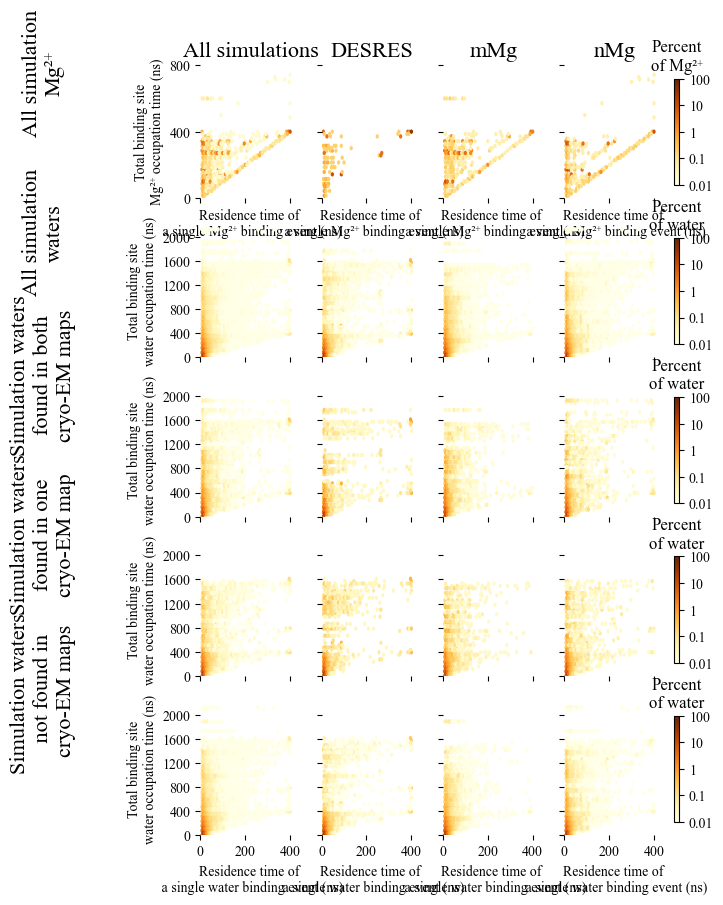

In [13]:
# plot by force field
titles_ = ["All simulations","DESRES","mMg","nMg"]
titles_2 = ["All simulation\nMg²⁺","All simulation\nwaters", "Simulation waters\nfound in both\ncryo-EM maps", "Simulation waters\nfound in one\ncryo-EM map", "Simulation waters \n not found in\ncryo-EM maps"]
wat['norm_sum_res_time'] = wat.sum_res_time/wat.occupancy

fig, axes= plt.subplots(5,4,figsize=(6,10),sharex=True,sharey='row')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def plot_heatmap(df,i,j,ymax=2200):
    x = df.res_time
    y = df.sum_res_time
    count = len(x)
    labels = [100,10,1,0.1,0.01]
    yticks = [count*x/100 for x in labels]
    im=axes[j,i].hexbin(x, y, gridsize=50,cmap='YlOrBr',extent=(0,400,0,ymax),bins='log',vmax=count,vmin=yticks[-1]) # ,bins='log' gist_heat_r
    if i ==3:
        axins = inset_axes(axes[j,i],width="5%",  height="80%",loc='center right',borderpad=-1)
        cb = fig.colorbar(im, cax=axins,pad=0.2)
        cb.ax.set_yticks(yticks,labels)
        print('ylim',cb.ax.get_ylim())
        if j==0:
            cb.ax.set_title('Percent\nof Mg²⁺')
        else:
            cb.ax.set_title('Percent\nof water')
    axes[j,i].set_frame_on(False)
    axes[j,i].axis([0, 450, 0, max(450,ymax)])
    axes[j,i].set_yticks(list(range(0,max(401,int(ymax)),400)))
    axes[j,i].set_xticks([0,200,400])
    if j == 0:
        axes[j,i].set_xlabel("Residence time of \n a single Mg²⁺ binding event (ns)")
        axes[j,i].set_title(titles_[i],size=16)
    if j == 4:
        axes[j,i].set_xlabel("Residence time of \n a single water binding event (ns)")
    if i == 0:
        axes[j,i].text(-700,ymax/2,titles_2[j],size=16,horizontalalignment='center',rotation=90)
        if j == 0:
            axes[j,i].set_ylabel("Total binding site\nMg²⁺ occupation time (ns)")
        else:
            axes[j,i].set_ylabel("Total binding site\nwater occupation time (ns)")
        
for j,ff in enumerate([0,'d','m','n']):
    if ff==0: df = mg
    else: df = mg[mg.simulation.str[-2]==ff]
    plot_heatmap(df,j,0,801)

for j,ff in enumerate([0,'d','m','n']):
    if ff == 0: df=wat
    else: df = wat[wat.simulation.str[-2]==ff]
    plot_heatmap(df,j,1)
    
    
for j,ff in enumerate([0,'d','m','n']):
    if ff == 0: df = wat[wat.em_state=='Water binding site found in both cryoEM maps.']
    else: df = wat[(wat.simulation.str[-2]==ff) & (wat.em_state=='Water binding site found in both cryoEM maps.')]
    plot_heatmap(df,j,2)
    
for j,ff in enumerate([0,'d','m','n']):
    if ff == 0: df = wat[wat.em_state=='Water binding site found in only one cryoEM maps.']    
    else: df = wat[(wat.simulation.str[-2]==ff) & (wat.em_state=='Water binding site found in only one cryoEM maps.')]
    plot_heatmap(df,j,3)
for j,ff in enumerate([0,'d','m','n']):
    if ff==0: df = wat[(wat.em_state=='Water binding site not found in any cryoEM maps.')]
    else: df = wat[(wat.simulation.str[-2]==ff) & (wat.em_state=='Water binding site not found in any cryoEM maps.')]
    plot_heatmap(df,j,4)
    
plt.subplots_adjust(wspace=0.2,hspace=0.2)
plt.savefig(f"figure_panels/residence_time_binding_sites.svg",bbox_inches="tight",transparent=True)
plt.savefig(f"figure_panels/residence_time_binding_sites.png", dpi=dpi,bbox_inches="tight",transparent=True)

ylim (4.8541, 48541.0)


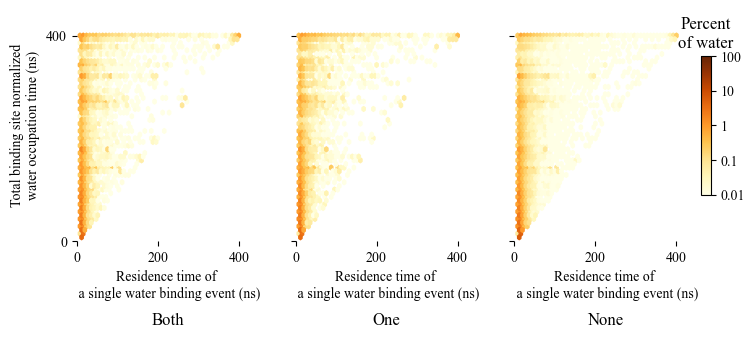

In [14]:
# plot by force field
titles_ = ["All simulations","DESRES","mMg","nMg"]
titles_2 = ["Both", "One", "None"]
fig, axes= plt.subplots(1,3,figsize=(8,3),sharex=True,sharey='row')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def plot_heatmap(df,j,ymax=400):#2200):
    x = df.res_time
    y = df.norm_sum_res_time
    count = len(x)
    labels = [100,10,1,0.1,0.01]
    yticks = [count*x/100 for x in labels]
    im=axes[j].hexbin(x, y, gridsize=50,cmap='YlOrBr',extent=(0,400,0,ymax),bins='log',vmax=count,vmin=yticks[-1]) # ,bins='log' gist_heat_r
    if j ==2:
        axins = inset_axes(axes[j],width="5%",  height="60%",loc='center right',borderpad=-1)
        cb = fig.colorbar(im, cax=axins,pad=0.2)
        cb.ax.set_yticks(yticks,labels)
        print('ylim',cb.ax.get_ylim())
        cb.ax.set_title('Percent\nof water')
    axes[j].set_frame_on(False)
    axes[j].axis([0, 450, 0, max(450,ymax)])
    axes[j].set_yticks(list(range(0,max(401,int(ymax)),400)))
    axes[j].set_xticks([0,200,400])
    axes[j].set_xlabel("Residence time of \n a single water binding event (ns)")
    axes[j].set_title(titles_2[j],y=-0.4)
    if j == 0:
        axes[j].set_ylabel("Total binding site normalized\nwater occupation time (ns)")#"Sum residence times \n of all waters for a \n RNA binding site (ns)")
        

    
df = wat[wat.em_state=='Water binding site found in both cryoEM maps.']
plot_heatmap(df,0)
    
df = wat[wat.em_state=='Water binding site found in only one cryoEM maps.']    
plot_heatmap(df,1)

df = wat[(wat.em_state=='Water binding site not found in any cryoEM maps.')]
plot_heatmap(df,2)
    
plt.subplots_adjust(wspace=0.2,hspace=0.2)
plt.savefig(f"figure_panels/residence_time_binding_sites_fig5.svg",bbox_inches="tight",transparent=True)
plt.savefig(f"figure_panels/residence_time_binding_sites_fig5.png", dpi=dpi,bbox_inches="tight",transparent=True)

In [8]:

d1 = wat_sum[wat_sum.em_state=="Water binding site found in both cryoEM maps."]
d2 = wat_sum[wat_sum.em_state=="Water binding site found in only one cryoEM maps."]
d3 = wat_sum[wat_sum.em_state=="Water binding site not found in any cryoEM maps."]

results_d1 = []
results_d2 = []
results_d3 = []
for x in range(400):
    results_d1.append([x,d1[d1['mean']<x]['mean/sum'].mean(),d1[d1['mean']<x]['mean/sum'].std()])
    results_d2.append([x,d2[d2['mean']<x]['mean/sum'].mean(),d2[d2['mean']<x]['mean/sum'].std()])
    results_d3.append([x,d3[d3['mean']<x]['mean/sum'].mean(),d3[d3['mean']<x]['mean/sum'].std()])
results_d1 = pd.DataFrame(results_d1,columns=['mean','mean/sum','std'])
results_d2 = pd.DataFrame(results_d2,columns=['mean','mean/sum','std'])
results_d3 = pd.DataFrame(results_d3,columns=['mean','mean/sum','std'])

ax = sns.lineplot(data=results_d1,x='mean',y='mean/sum',color='blue')
ax2 = sns.lineplot(data=results_d2,x='mean',y='mean/sum',color='green')
ax3 = sns.lineplot(data=results_d3,x='mean',y='mean/sum',color='red')

ax.fill_between(results_d1['mean'], results_d1['mean/sum']-results_d1['std'],  results_d1['mean/sum']+results_d1['std'], alpha=0.2,color='blue')
ax2.fill_between(results_d2['mean'], results_d2['mean/sum']-results_d2['std'],  results_d2['mean/sum']+results_d2['std'], alpha=0.2,color='green')
ax3.fill_between(results_d3['mean'], results_d3['mean/sum']-results_d3['std'],  results_d3['mean/sum']+results_d3['std'], alpha=0.2,color='red')

KeyError: 'mean/sum'

In [9]:

d1 = wat_sum[wat_sum.em_state=="Water binding site found in both cryoEM maps."]
d2 = wat_sum[wat_sum.em_state=="Water binding site found in only one cryoEM maps."]
d3 = wat_sum[wat_sum.em_state=="Water binding site not found in any cryoEM maps."]

results_d1 = []
results_d2 = []
results_d3 = []
for x in range(400):
    results_d1.append([x,d1[d1['mean']>x]['mean/sum'].mean(),d1[d1['mean']>x]['mean/sum'].std()])
    results_d2.append([x,d2[d2['mean']>x]['mean/sum'].mean(),d2[d2['mean']>x]['mean/sum'].std()])
    results_d3.append([x,d3[d3['mean']>x]['mean/sum'].mean(),d3[d3['mean']>x]['mean/sum'].std()])
results_d1 = pd.DataFrame(results_d1,columns=['mean','mean/sum','std'])
results_d2 = pd.DataFrame(results_d2,columns=['mean','mean/sum','std'])
results_d3 = pd.DataFrame(results_d3,columns=['mean','mean/sum','std'])

ax = sns.lineplot(data=results_d1,x='mean',y='mean/sum',color='blue')
ax2 = sns.lineplot(data=results_d2,x='mean',y='mean/sum',color='green')
ax3 = sns.lineplot(data=results_d3,x='mean',y='mean/sum',color='red')

ax.fill_between(results_d1['mean'], results_d1['mean/sum']-results_d1['std'],  results_d1['mean/sum']+results_d1['std'], alpha=0.2,color='blue')
ax2.fill_between(results_d2['mean'], results_d2['mean/sum']-results_d2['std'],  results_d2['mean/sum']+results_d2['std'], alpha=0.2,color='green')
ax3.fill_between(results_d3['mean'], results_d3['mean/sum']-results_d3['std'],  results_d3['mean/sum']+results_d3['std'], alpha=0.2,color='red')

KeyError: 'mean/sum'

In [ ]:
d1 = wat_sum[wat_sum.em_state=="Water binding site found in both cryoEM maps."]
d2 = wat_sum[wat_sum.em_state=="Water binding site found in only one cryoEM maps."]
d3 = wat_sum[wat_sum.em_state=="Water binding site not found in any cryoEM maps."]

results_d1 = []
results_d2 = []
results_d3 = []
for x in range(400):
    results_d1.append([x,d1[d1['sum']<x]['mean/sum'].mean(),d1[d1['sum']<x]['mean/sum'].std()])
    results_d2.append([x,d2[d2['sum']<x]['mean/sum'].mean(),d2[d2['sum']<x]['mean/sum'].std()])
    results_d3.append([x,d3[d3['sum']<x]['mean/sum'].mean(),d3[d3['sum']<x]['mean/sum'].std()])
results_d1 = pd.DataFrame(results_d1,columns=['sum','mean/sum','std'])
results_d2 = pd.DataFrame(results_d2,columns=['sum','mean/sum','std'])
results_d3 = pd.DataFrame(results_d3,columns=['sum','mean/sum','std'])

ax = sns.lineplot(data=results_d1,x='sum',y='mean/sum',color='blue')
ax2 = sns.lineplot(data=results_d2,x='sum',y='mean/sum',color='green')
ax3 = sns.lineplot(data=results_d3,x='sum',y='mean/sum',color='red')

ax.fill_between(results_d1['sum'], results_d1['mean/sum']-results_d1['std'],  results_d1['mean/sum']+results_d1['std'], alpha=0.2,color='blue')
ax2.fill_between(results_d2['sum'], results_d2['mean/sum']-results_d2['std'],  results_d2['mean/sum']+results_d2['std'], alpha=0.2,color='green')
ax3.fill_between(results_d3['sum'], results_d3['mean/sum']-results_d3['std'],  results_d3['mean/sum']+results_d3['std'], alpha=0.2,color='red')

In [ ]:
d1 = wat_sum[wat_sum.em_state=="Water binding site found in both cryoEM maps."]
d2 = wat_sum[wat_sum.em_state=="Water binding site found in only one cryoEM maps."]
d3 = wat_sum[wat_sum.em_state=="Water binding site not found in any cryoEM maps."]

results_d1 = []
results_d2 = []
results_d3 = []
for x in range(400):
    results_d1.append([x,d1[d1['sum']>x]['mean/sum'].mean(),d1[d1['sum']>x]['mean/sum'].std()])
    results_d2.append([x,d2[d2['sum']>x]['mean/sum'].mean(),d2[d2['sum']>x]['mean/sum'].std()])
    results_d3.append([x,d3[d3['sum']>x]['mean/sum'].mean(),d3[d3['sum']>x]['mean/sum'].std()])
results_d1 = pd.DataFrame(results_d1,columns=['sum','mean/sum','std'])
results_d2 = pd.DataFrame(results_d2,columns=['sum','mean/sum','std'])
results_d3 = pd.DataFrame(results_d3,columns=['sum','mean/sum','std'])

ax = sns.lineplot(data=results_d1,x='sum',y='mean/sum',color='blue')
ax2 = sns.lineplot(data=results_d2,x='sum',y='mean/sum',color='green')
ax3 = sns.lineplot(data=results_d3,x='sum',y='mean/sum',color='red')

ax.fill_between(results_d1['sum'], results_d1['mean/sum']-results_d1['std'],  results_d1['mean/sum']+results_d1['std'], alpha=0.2,color='blue')
ax2.fill_between(results_d2['sum'], results_d2['mean/sum']-results_d2['std'],  results_d2['mean/sum']+results_d2['std'], alpha=0.2,color='green')
ax3.fill_between(results_d3['sum'], results_d3['mean/sum']-results_d3['std'],  results_d3['mean/sum']+results_d3['std'], alpha=0.2,color='red')

In [ ]:
wat_sum['sum/occupancy'] = wat_sum['sum']/wat_sum['occupancy']
d1 = wat_sum[wat_sum.em_state=="Water binding site found in both cryoEM maps."]
d2 = wat_sum[wat_sum.em_state=="Water binding site found in only one cryoEM maps."]
d3 = wat_sum[wat_sum.em_state=="Water binding site not found in any cryoEM maps."]

results_d1 = []
results_d2 = []
results_d3 = []
for x in range(400):
    results_d1.append([x,d1[d1['sum/occupancy']<x]['mean/sum'].mean(),d1[d1['sum/occupancy']<x]['mean/sum'].std()])
    results_d2.append([x,d2[d2['sum/occupancy']<x]['mean/sum'].mean(),d2[d2['sum/occupancy']<x]['mean/sum'].std()])
    results_d3.append([x,d3[d3['sum/occupancy']<x]['mean/sum'].mean(),d3[d3['sum/occupancy']<x]['mean/sum'].std()])
results_d1 = pd.DataFrame(results_d1,columns=['sum/occupancy','mean/sum','std'])
results_d2 = pd.DataFrame(results_d2,columns=['sum/occupancy','mean/sum','std'])
results_d3 = pd.DataFrame(results_d3,columns=['sum/occupancy','mean/sum','std'])

ax = sns.lineplot(data=results_d1,x='sum/occupancy',y='mean/sum',color='blue')
ax2 = sns.lineplot(data=results_d2,x='sum/occupancy',y='mean/sum',color='green')
ax3 = sns.lineplot(data=results_d3,x='sum/occupancy',y='mean/sum',color='red')

ax.fill_between(results_d1['sum/occupancy'], results_d1['mean/sum']-results_d1['std'],  results_d1['mean/sum']+results_d1['std'], alpha=0.2,color='blue')
ax2.fill_between(results_d2['sum/occupancy'], results_d2['mean/sum']-results_d2['std'],  results_d2['mean/sum']+results_d2['std'], alpha=0.2,color='green')
ax3.fill_between(results_d3['sum/occupancy'], results_d3['mean/sum']-results_d3['std'],  results_d3['mean/sum']+results_d3['std'], alpha=0.2,color='red')

In [ ]:
fig, axes= plt.subplots(1,1,figsize=(8,4))

wat_sum['sum/occupancy'] = wat_sum['sum']/wat_sum['occupancy']
d1 = wat_sum[wat_sum.em_state=="Water binding site found in both cryoEM maps."]
d2 = wat_sum[wat_sum.em_state=="Water binding site found in only one cryoEM maps."]
d3 = wat_sum[wat_sum.em_state=="Water binding site not found in any cryoEM maps."]

results_d1 = []
results_d2 = []
results_d3 = []
for x in range(400):
    results_d1.append([x,d1[d1['sum/occupancy']>x]['mean/sum'].mean(),d1[d1['sum/occupancy']>x]['mean/sum'].std()])
    results_d2.append([x,d2[d2['sum/occupancy']>x]['mean/sum'].mean(),d2[d2['sum/occupancy']>x]['mean/sum'].std()])
    results_d3.append([x,d3[d3['sum/occupancy']>x]['mean/sum'].mean(),d3[d3['sum/occupancy']>x]['mean/sum'].std()])
results_d1 = pd.DataFrame(results_d1,columns=['sum/occupancy','mean/sum','std'])
results_d2 = pd.DataFrame(results_d2,columns=['sum/occupancy','mean/sum','std'])
results_d3 = pd.DataFrame(results_d3,columns=['sum/occupancy','mean/sum','std'])

ax = sns.lineplot(data=results_d1,x='sum/occupancy',y='mean/sum',color='blue')
ax2 = sns.lineplot(data=results_d2,x='sum/occupancy',y='mean/sum',color='green')
ax3 = sns.lineplot(data=results_d3,x='sum/occupancy',y='mean/sum',color='red')

ax.plot(results_d1['sum/occupancy'], results_d1['mean/sum']-results_d1['std'],  alpha=0.2,color='blue')
ax.plot(results_d1['sum/occupancy'], results_d1['mean/sum']+results_d1['std'],  alpha=0.2,color='blue')

ax2.plot(results_d2['sum/occupancy'], results_d2['mean/sum']-results_d2['std'],  alpha=0.2,color='green')
ax2.plot(results_d2['sum/occupancy'], results_d2['mean/sum']+results_d2['std'],  alpha=0.2,color='green')

ax3.plot(results_d3['sum/occupancy'], results_d3['mean/sum']-results_d3['std'], alpha=0.2,color='red')
ax3.plot(results_d3['sum/occupancy'], results_d3['mean/sum']+results_d3['std'], alpha=0.2,color='red')

ax.set_xlim(400,10)

In [15]:
# get residence time per atom
mg_out = f"../analysis/Mg_restimes_dist2.2_time10_skip1.csv"
na_out = f"../analysis/Na_restimes_dist2.5_time10_skip1.csv"
wat_out = f"../analysis/wat_restimes_dist3.2_time10_skip1.csv"

mg_in = f"../analysis/Mg_reports_dist2.2_time10_skip1.csv"
na_in = f"../analysis/Na_reports_dist2.5_time10_skip1.csv"
wat_in = f"../analysis/wat_reports_dist3.2_time10_skip1.csv"
mgin = pd.read_csv(mg_in)
nain = pd.read_csv(na_in)
watin = pd.read_csv(wat_in)
occupancy_modena = nain.drop(columns=["other_atom"]).groupby(['simulation','RNA_atom']).count().replace(0, np.NaN).mode(axis=1)[0].to_dict() 
occupancy_modemg = mgin.drop(columns=["other_atom"]).groupby(['simulation','RNA_atom']).count().replace(0, np.NaN).mode(axis=1)[0].to_dict() # time at each column
occupancy_modewat = watin.drop(columns=["other_atom"]).groupby(['simulation','RNA_atom']).count().replace(0, np.NaN).mode(axis=1)[0].to_dict() # time at each column
mg = pd.read_csv(mg_out)
na = pd.read_csv(na_out)
wat = pd.read_csv(wat_out)
mg['sum_res_time'] = mg.groupby(['RNA_atom','simulation','atom'])['res_time'].transform('sum')
na['sum_res_time'] = na.groupby(['RNA_atom','simulation','atom'])['res_time'].transform('sum')
wat['sum_res_time'] = wat.groupby(['RNA_atom','simulation','atom'])['res_time'].transform('sum')
mg['occ_mode']=mg.apply(lambda r: occupancy_modemg.get((r.simulation,r.RNA_atom),0), axis=1)
na['occ_mode']=na.apply(lambda r: occupancy_modena.get((r.simulation,r.RNA_atom),0), axis=1)
wat['occ_mode']=wat.apply(lambda r: occupancy_modewat.get((r.simulation,r.RNA_atom),0), axis=1) # 279_U_O2'

In [ ]:
fig, axes= plt.subplots(3,3,figsize=(4,5.5))
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
titles_ = ["All simulations","DESRES","mMg","nMg"]

for j,ff in enumerate(['d','m','n']):
    print(ff)
    df = mg[mg.simulation.str[-2]==ff]
    
    atoms=["OP","O2'","base carbonyl"]
    atoms2 = list(df.atom.unique())
    #if 'base secondary ketimine' in atoms:
    #    atoms.remove('base secondary ketimine')
    for i,atom in enumerate(atoms):
        x = df[df.atom==atom].res_time
        y = df[df.atom==atom].sum_res_time
        count = len(x)
        labels = [100,10,1,0.1]
        yticks = [count*x/100 for x in labels]
        if atom in atoms2 and x.max()==x.max():
            im=axes[j,i].hexbin(x, y, gridsize=20,cmap='Greens',extent=(0,400,0,400),bins='log',vmax=count,vmin=yticks[-1])#bone_r
            print(im.get_array().max())
        axes[j,i].axis([0, 450, 0, 450])
        if i ==2 and j==1:
            axins = inset_axes(axes[j,i],
                    width="5%",  
                    height="80%",
                    loc='center right',
                    borderpad=-2
                   )
            cb = fig.colorbar(im, cax=axins,pad=0.2)
            cb.ax.set_yticks(yticks,labels)
            print('ylim',cb.ax.get_ylim())
            cb.ax.set_title('Percent\nof Mg²⁺')
        if j == 0:
            axes[j,i].set_title(atom,size=16)
        if i!= 0:
            axes[j,i].set_yticks([])
        if j != 2:
            axes[j,i].set_xticks([])
        if i == 0 and j==1:
            axes[j,i].set_ylabel("Sum residence times of all Mg²⁺ \n for this RNA atom (ns)")
        if i ==0:
            axes[j,i].text(-600,200,titles_[j+1],size=16,horizontalalignment='center')
        axes[j,i].spines[['right', 'top']].set_visible(False)
        if j == 2 and i==1:
            axes[j,i].set_xlabel("Residence time of a single Mg²⁺ (ns)")
plt.subplots_adjust(wspace=0.2)
# not much interesting past 400!
plt.savefig(f"figure_panels/residence_time_atom_mg.svg",bbox_inches="tight",transparent=True)
plt.savefig(f"figure_panels/residence_time_atom_mg.png", dpi=dpi,bbox_inches="tight",transparent=True)

OP
1667.0
O2'
302.0
base carbonyl
238.0
base secondary ketimine
655.0
base primary amine
139.0
base primary ketimine
21.0
OP
1820.0
O2'
328.0
base carbonyl
235.0
base secondary ketimine
856.0
base primary amine
214.0
base primary ketimine
35.0
ylim (0.028999999999999998, 290.0)
(0.028999999999999998, 290.0)
OP
1668.0
O2'
300.0
base carbonyl
208.0
base secondary ketimine
723.0
base primary amine
207.0
base primary ketimine
30.0


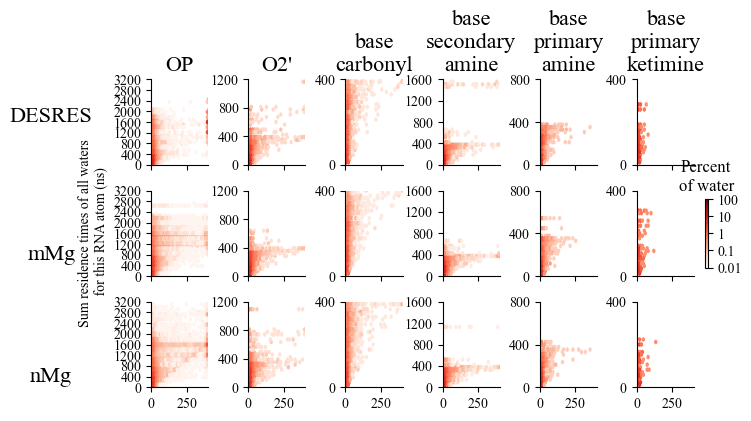

In [17]:
fig, axes= plt.subplots(3,6,figsize=(7,4),sharey=False,sharex=True)
from matplotlib import ticker as mticker
maxs = [1748,402,252,730,791,138,27]
ymaxs = [3200,1200,400,1600,800,400,400]

for j,ff in enumerate(['d','m','n']): #0,
    if ff ==0 : df = wat
    else:df = wat[wat.simulation.str[-2]==ff]
    
    atoms = list(df.atom.unique())
    atoms = ['OP',"O2'","base carbonyl","base secondary ketimine","base primary amine","base primary ketimine"] #,"other sugar"
    if 'carbon or phosphorous' in atoms:
        atoms.remove('carbon or phosphorous')
    if 'base tertiary amine' in atoms:
        atoms.remove('base tertiary amine')
    other_sugar = ["O5'", "O3'", "O4'"]
    for f in other_sugar:
        if f in atoms:
            atoms.remove(f)

    #atoms.remove('base secondary ketimine')
    for i,atom in enumerate(atoms):
        if atom != "other sugar":
            x = df[df.atom==atom].res_time
            y = df[df.atom==atom].sum_res_time
        else:
            x = df[df.atom.isin(other_sugar)].res_time
            y = df[df.atom.isin(other_sugar)].sum_res_time
        print(atom)
        count = len(x)
        if count == 0:
            continue
        labels = [100,10,1,0.1,0.01]
        yticks = [count*x/100 for x in labels]
        #print(count,yticks[-1])
        im=axes[j,i].hexbin(x, y,gridsize=30,cmap='Reds',bins='log',extent = (0, 400, 0, ymaxs[i]),vmin=yticks[-1],vmax=count)#,vmax=maxs[j], extent = (0, 400, 0, ymaxs[j])) # , bins='log'
        print(im.get_array().max())
        axes[j,i].axis([0, 400, 0, ymaxs[i]])
        #cb = plt.colorbar()
        if j==0:
            #axes[j,i].text(0,ymaxs[j]/2,atom,size=16,horizontalalignment='center')
            if atom == "base secondary ketimine":
                atom = "base secondary amine"
            axes[j,i].set_title(atom.replace(" ","\n"),size=16)
        if i ==5 and j==1:
            axins = inset_axes(axes[j,i],width="5%",height="80%",loc='center right',borderpad=-1)
            cb = fig.colorbar(im, cax=axins,pad=0.2)
            print('ylim',cb.ax.get_ylim())
            cb.ax.set_yticks(yticks,labels,size=10)
            print(cb.ax.get_ylim())
            cb.ax.set_title('Percent\nof water')
        if i == 0:
            
            #axes[j,i].set_title(titles_[j])
            axes[j,i].text(-700,ymaxs[j]/2,titles_[j+1],size=16,horizontalalignment='center')
        if i==0 and j==1:
            axes[j,i].set_ylabel("Sum residence times of all waters\n for this RNA atom (ns)")
        axes[j,i].spines[['right', 'top']].set_visible(False)
        axes[j,i].set_yticks(list(range(0,ymaxs[i]+1,400)),size=10)
        if j == 6:
            axes[j,i].set_xlabel("Residence time of \n a single water (ns)")
plt.subplots_adjust(wspace=0.7,hspace=0.3)
plt.savefig(f"figure_panels/residence_time_atom_water.svg",bbox_inches="tight",transparent=True)
plt.savefig(f"figure_panels/residence_time_atom_water.png", dpi=dpi,bbox_inches="tight",transparent=True)